# Patch Verification Results Analysis

This notebook provides comprehensive analysis of patch testing results from the verification pipeline.

## Contents
1. Setup & Data Loading
2. Overview Dashboard
3. Static Analysis Deep Dive
4. Fuzzing & Testing Analysis
5. Rules Engine Analysis
6. Comparative Analysis
7. Failure Analysis
8. Performance Metrics

## 1. Setup & Data Loading

In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from collections import defaultdict, Counter
import warnings

warnings.filterwarnings('ignore')

# Set style for better-looking plots
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

# Results directory
RESULTS_DIR = Path('/fs/nexus-scratch/ihbas/verifier_harness/results')

print(f"Results directory: {RESULTS_DIR}")
print(f"Directory exists: {RESULTS_DIR.exists()}")

Results directory: /fs/nexus-scratch/ihbas/verifier_harness/results
Directory exists: True


In [2]:
def load_all_results(results_dir=RESULTS_DIR):
    """Load all JSON results from the results directory."""
    results = []
    json_files = list(results_dir.glob('*.json'))
    
    print(f"Found {len(json_files)} JSON files")
    
    for json_file in json_files:
        try:
            with open(json_file, 'r') as f:
                data = json.load(f)
                results.append(data)
        except Exception as e:
            print(f"Error loading {json_file.name}: {e}")
    
    print(f"Successfully loaded {len(results)} results")
    return results

def results_to_dataframe(results):
    """Convert results to a pandas DataFrame for easier analysis."""
    rows = []
    
    for r in results:
        row = {
            'instance_id': r.get('instance_id'),
            'success': r.get('success'),
            'repo': r.get('repo', '').split('/')[-1] if r.get('repo') else 'unknown',
            'elapsed_seconds': r.get('elapsed_seconds'),
            'verdict': r.get('verdict'),
            'overall_score': r.get('overall_score'),
            'container_from_cache': r.get('container_from_cache'),
        }
        
        # Static analysis data
        if 'static' in r and isinstance(r['static'], dict):
            row['static_sqi_score'] = r['static'].get('sqi_score')
            row['static_passed'] = r['static'].get('passed')
            row['static_total_loc'] = r['static'].get('meta', {}).get('total_loc')
            row['static_n_files'] = r['static'].get('meta', {}).get('n_files')
            
            # Linter issues
            analyzers = r['static'].get('analyzers', {})
            row['pylint_issues'] = analyzers.get('pylint', {}).get('total_issues', 0)
            row['flake8_issues'] = len(analyzers.get('flake8', {}).get('issues', []))
            row['bandit_issues'] = len(analyzers.get('bandit', {}).get('issues', []))
            row['mypy_errors'] = analyzers.get('mypy', {}).get('total_errors', 0)
            
            # Radon complexity
            radon = analyzers.get('radon', {})
            row['radon_avg_complexity'] = radon.get('average_complexity')
            row['radon_maintainability'] = radon.get('average_maintainability')
        
        # Fuzzing data
        if 'fuzzing' in r and isinstance(r['fuzzing'], dict):
            fuzz = r['fuzzing']
            row['fuzzing_passed'] = fuzz.get('passed')
            row['tests_passed'] = fuzz.get('tests_passed')
            row['tests_generated'] = fuzz.get('tests_generated')
            row['baseline_coverage'] = fuzz.get('baseline_coverage')
            row['combined_coverage'] = fuzz.get('combined_coverage')
            row['coverage_improvement'] = fuzz.get('improvement')
            row['divergences_detected'] = fuzz.get('divergences_detected')
            row['divergence_count'] = fuzz.get('divergence_count')
            
            # Baseline tests
            baseline = fuzz.get('details', {}).get('baseline_tests', {})
            row['baseline_test_count'] = baseline.get('count')
            row['baseline_tests_passed'] = baseline.get('passed')
            row['fail_to_pass'] = baseline.get('fail_to_pass')
            row['pass_to_pass'] = baseline.get('pass_to_pass')
        
        # Rules data
        if 'rules' in r and isinstance(r['rules'], dict):
            rules = r['rules']
            row['rules_passed'] = rules.get('passed')
            row['rules_total'] = rules.get('total_rules')
            row['rules_failed'] = rules.get('failed_rules')
            row['findings_count'] = rules.get('findings_count')
            row['high_severity'] = rules.get('high_severity_count')
            row['medium_severity'] = rules.get('medium_severity_count')
            row['low_severity'] = rules.get('low_severity_count')
        
        # Error if failed
        row['error'] = r.get('error', '')[:100] if r.get('error') else None
        
        rows.append(row)
    
    df = pd.DataFrame(rows)
    
    # Convert elapsed time to minutes
    if 'elapsed_seconds' in df.columns:
        df['elapsed_minutes'] = df['elapsed_seconds'] / 60
    
    return df

In [3]:
# Load all results
results = load_all_results()
df = results_to_dataframe(results)

print(f"\nDataFrame shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")

# Filter out results that don't pass baseline tests
print(f"\n{'='*80}")
print("BASELINE TEST FILTERING")
print('='*80)
print(f"Total results loaded: {len(df)}")
print(f"Results with baseline test data: {df['baseline_tests_passed'].notna().sum()}")
print(f"Results that PASS baseline tests: {(df['baseline_tests_passed'] == True).sum()}")
print(f"Results that FAIL baseline tests: {(df['baseline_tests_passed'] == False).sum()}")

# Create filtered dataframe (only results that pass baseline tests)
df_filtered = df[df['baseline_tests_passed'] == True].copy()
print(f"\nFiltered DataFrame shape (baseline passed): {df_filtered.shape}")
print(f"Filtered out: {len(df) - len(df_filtered)} instances that failed baseline tests")

print(f"\nNOTE: All subsequent analyses will use df_filtered (only instances passing baseline tests)")

Found 52 JSON files
Successfully loaded 52 results

DataFrame shape: (52, 38)
Columns: ['instance_id', 'success', 'repo', 'elapsed_seconds', 'verdict', 'overall_score', 'container_from_cache', 'static_sqi_score', 'static_passed', 'static_total_loc', 'static_n_files', 'pylint_issues', 'flake8_issues', 'bandit_issues', 'mypy_errors', 'radon_avg_complexity', 'radon_maintainability', 'fuzzing_passed', 'tests_passed', 'tests_generated', 'baseline_coverage', 'combined_coverage', 'coverage_improvement', 'divergences_detected', 'divergence_count', 'baseline_test_count', 'baseline_tests_passed', 'fail_to_pass', 'pass_to_pass', 'rules_passed', 'rules_total', 'rules_failed', 'findings_count', 'high_severity', 'medium_severity', 'low_severity', 'error', 'elapsed_minutes']

BASELINE TEST FILTERING
Total results loaded: 52
Results with baseline test data: 49
Results that PASS baseline tests: 37
Results that FAIL baseline tests: 12

Filtered DataFrame shape (baseline passed): (37, 38)
Filtered out: 1

## 2. Overview Dashboard

High-level metrics and success rates across all instances.

In [4]:
# Summary statistics (using filtered data)
print("=" * 80)
print("OVERALL SUMMARY (Only instances passing baseline tests)")
print("=" * 80)
print(f"Total instances processed: {len(df_filtered)}")
print(f"Successful runs: {df_filtered['success'].sum()} ({df_filtered['success'].mean()*100:.1f}%)")
print(f"Failed runs: {(~df_filtered['success']).sum()} ({(~df_filtered['success']).mean()*100:.1f}%)")
print(f"\nUnique repositories: {df_filtered['repo'].nunique()}")
print(f"Repositories: {', '.join(df_filtered['repo'].unique())}")
print(f"\nAverage execution time: {df_filtered['elapsed_minutes'].mean():.2f} minutes")
print(f"Median execution time: {df_filtered['elapsed_minutes'].median():.2f} minutes")
print(f"Total processing time: {df_filtered['elapsed_minutes'].sum():.2f} minutes ({df_filtered['elapsed_minutes'].sum()/60:.2f} hours)")

# Success rate by repository
print("\n" + "=" * 80)
print("SUCCESS RATE BY REPOSITORY")
print("=" * 80)
repo_stats = df_filtered.groupby('repo').agg({
    'success': ['count', 'sum', 'mean'],
    'elapsed_minutes': 'mean'
}).round(2)
repo_stats.columns = ['Total', 'Successful', 'Success Rate', 'Avg Time (min)']
repo_stats['Success Rate'] = (repo_stats['Success Rate'] * 100).round(1).astype(str) + '%'
print(repo_stats)

OVERALL SUMMARY (Only instances passing baseline tests)
Total instances processed: 37
Successful runs: 37 (100.0%)
Failed runs: 0 (0.0%)

Unique repositories: 4
Repositories: astropy, django, matplotlib, scikit-learn

Average execution time: 5.20 minutes
Median execution time: 2.72 minutes
Total processing time: 192.34 minutes (3.21 hours)

SUCCESS RATE BY REPOSITORY
              Total  Successful Success Rate  Avg Time (min)
repo                                                        
astropy          16          16       100.0%            7.78
django            5           5       100.0%            2.59
matplotlib        6           6       100.0%            2.67
scikit-learn     10          10       100.0%            3.89


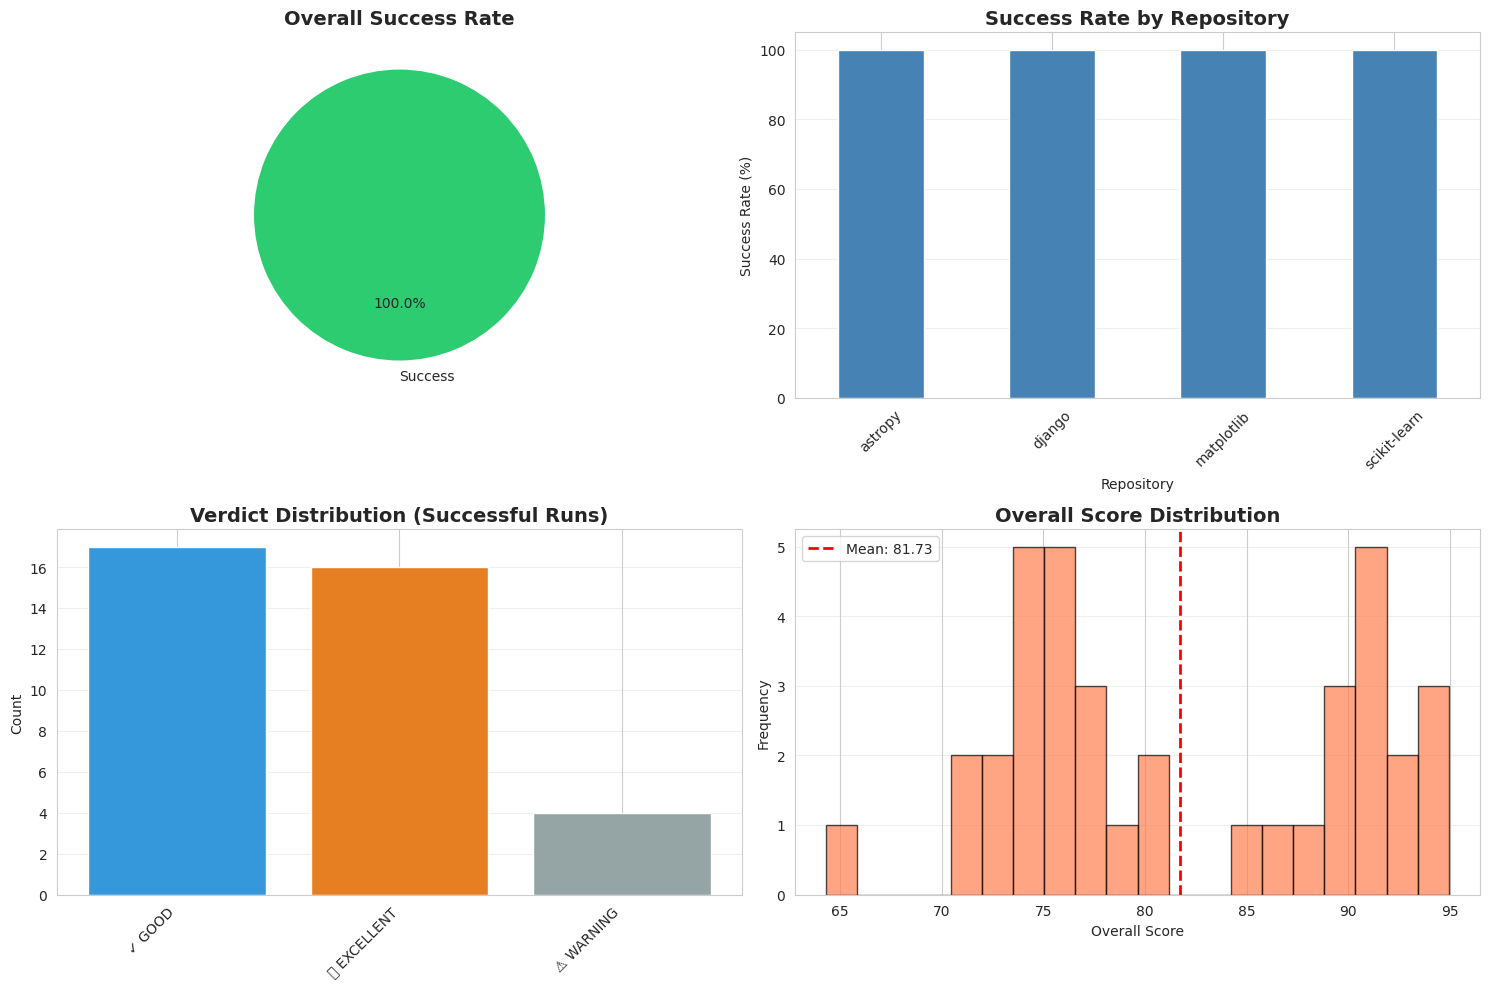

In [5]:
# Visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Success vs Failure pie chart
success_counts = df_filtered['success'].value_counts()
# Generate labels dynamically based on actual values present
labels = ['Success' if idx else 'Failure' for idx in success_counts.index]
axes[0, 0].pie(success_counts, labels=labels, autopct='%1.1f%%', 
               colors=['#2ecc71', '#e74c3c'][:len(success_counts)], startangle=90)
axes[0, 0].set_title('Overall Success Rate', fontsize=14, fontweight='bold')

# 2. Success rate by repository
repo_success = df_filtered.groupby('repo')['success'].agg(['sum', 'count'])
repo_success['rate'] = (repo_success['sum'] / repo_success['count'] * 100)
repo_success['rate'].plot(kind='bar', ax=axes[0, 1], color='steelblue')
axes[0, 1].set_title('Success Rate by Repository', fontsize=14, fontweight='bold')
axes[0, 1].set_ylabel('Success Rate (%)')
axes[0, 1].set_xlabel('Repository')
axes[0, 1].tick_params(axis='x', rotation=45)
axes[0, 1].grid(axis='y', alpha=0.3)

# 3. Verdict distribution (for successful runs)
successful_df = df_filtered[df_filtered['success'] == True]
if 'verdict' in df_filtered.columns and successful_df['verdict'].notna().any():
    verdict_counts = successful_df['verdict'].value_counts()
    axes[1, 0].bar(range(len(verdict_counts)), verdict_counts.values, 
                   color=['#3498db', '#e67e22', '#95a5a6'])
    axes[1, 0].set_xticks(range(len(verdict_counts)))
    axes[1, 0].set_xticklabels(verdict_counts.index, rotation=45, ha='right')
    axes[1, 0].set_title('Verdict Distribution (Successful Runs)', fontsize=14, fontweight='bold')
    axes[1, 0].set_ylabel('Count')
    axes[1, 0].grid(axis='y', alpha=0.3)
else:
    axes[1, 0].text(0.5, 0.5, 'No verdict data available', 
                    ha='center', va='center', fontsize=12)
    axes[1, 0].set_title('Verdict Distribution', fontsize=14, fontweight='bold')

# 4. Overall score distribution
if 'overall_score' in df_filtered.columns and df_filtered['overall_score'].notna().any():
    axes[1, 1].hist(df_filtered['overall_score'].dropna(), bins=20, color='coral', edgecolor='black', alpha=0.7)
    axes[1, 1].axvline(df_filtered['overall_score'].mean(), color='red', linestyle='--', 
                       linewidth=2, label=f'Mean: {df_filtered["overall_score"].mean():.2f}')
    axes[1, 1].set_title('Overall Score Distribution', fontsize=14, fontweight='bold')
    axes[1, 1].set_xlabel('Overall Score')
    axes[1, 1].set_ylabel('Frequency')
    axes[1, 1].legend()
    axes[1, 1].grid(axis='y', alpha=0.3)
else:
    axes[1, 1].text(0.5, 0.5, 'No score data available', 
                    ha='center', va='center', fontsize=12)
    axes[1, 1].set_title('Overall Score Distribution', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

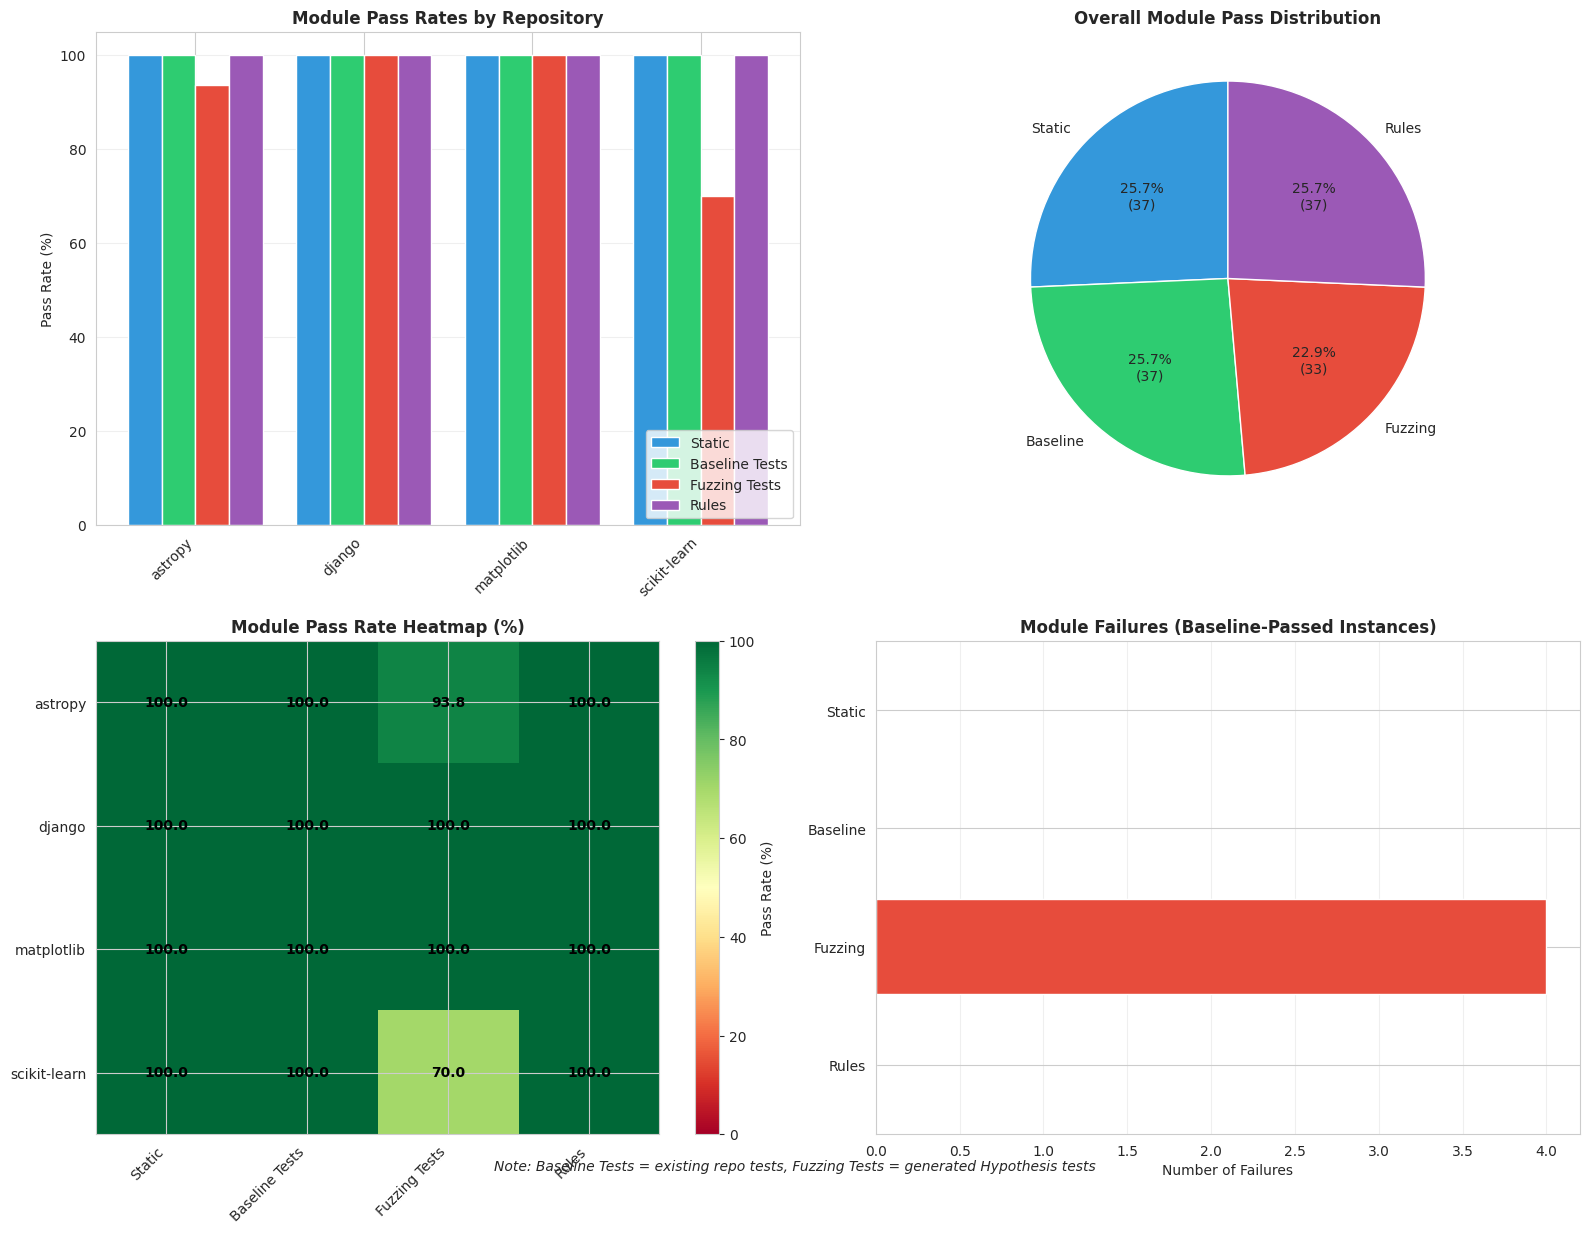

In [6]:
# Visualizations for module test pass rates
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Module pass rates - stacked bar chart by repository
repos = df_filtered['repo'].unique()
modules = ['static_passed', 'baseline_tests_passed', 'fuzzing_passed', 'rules_passed']
module_names = ['Static', 'Baseline Tests', 'Fuzzing Tests', 'Rules']

pass_rates = []
for repo in repos:
    repo_data = df_filtered[df_filtered['repo'] == repo]
    rates = [(repo_data[mod] == True).mean() * 100 for mod in modules]
    pass_rates.append(rates)

x = np.arange(len(repos))
width = 0.2
colors = ['#3498db', '#2ecc71', '#e74c3c', '#9b59b6']

for i, (module_name, color) in enumerate(zip(module_names, colors)):
    values = [rates[i] for rates in pass_rates]
    axes[0, 0].bar(x + i*width, values, width, label=module_name, color=color)

axes[0, 0].set_ylabel('Pass Rate (%)')
axes[0, 0].set_title('Module Pass Rates by Repository', fontsize=12, fontweight='bold')
axes[0, 0].set_xticks(x + width * 1.5)
axes[0, 0].set_xticklabels(repos, rotation=45, ha='right')
axes[0, 0].legend(loc='lower right')
axes[0, 0].grid(axis='y', alpha=0.3)
axes[0, 0].set_ylim([0, 105])

# 2. Overall module pass rates - pie/donut chart
overall_pass_counts = {
    'Static': (df_filtered['static_passed'] == True).sum(),
    'Baseline': (df_filtered['baseline_tests_passed'] == True).sum(),
    'Fuzzing': (df_filtered['fuzzing_passed'] == True).sum(),
    'Rules': (df_filtered['rules_passed'] == True).sum()
}

axes[0, 1].pie(overall_pass_counts.values(), labels=overall_pass_counts.keys(), 
               autopct=lambda pct: f'{pct:.1f}%\n({int(pct/100.*sum(overall_pass_counts.values()))})', 
               colors=colors, startangle=90)
axes[0, 1].set_title('Overall Module Pass Distribution', fontsize=12, fontweight='bold')

# 3. Module pass rate heatmap by repository
heatmap_data = []
for repo in repos:
    repo_data = df_filtered[df_filtered['repo'] == repo]
    rates = [(repo_data[mod] == True).mean() * 100 for mod in modules]
    heatmap_data.append(rates)

heatmap_df = pd.DataFrame(heatmap_data, index=repos, columns=module_names)
im = axes[1, 0].imshow(heatmap_df.values, cmap='RdYlGn', aspect='auto', vmin=0, vmax=100)
axes[1, 0].set_xticks(range(len(module_names)))
axes[1, 0].set_yticks(range(len(repos)))
axes[1, 0].set_xticklabels(module_names, rotation=45, ha='right')
axes[1, 0].set_yticklabels(repos)
axes[1, 0].set_title('Module Pass Rate Heatmap (%)', fontsize=12, fontweight='bold')

# Add values to heatmap
for i in range(len(repos)):
    for j in range(len(module_names)):
        text = axes[1, 0].text(j, i, f'{heatmap_df.values[i, j]:.1f}',
                               ha="center", va="center", color="black", fontsize=10, fontweight='bold')

plt.colorbar(im, ax=axes[1, 0], label='Pass Rate (%)')

# 4. Module failure analysis - count of failures by module
failure_counts = {
    'Static': (df_filtered['static_passed'] != True).sum(),
    'Baseline': (df_filtered['baseline_tests_passed'] != True).sum(),
    'Fuzzing': (df_filtered['fuzzing_passed'] != True).sum(),
    'Rules': (df_filtered['rules_passed'] != True).sum()
}

axes[1, 1].barh(range(len(failure_counts)), list(failure_counts.values()), color=colors)
axes[1, 1].set_yticks(range(len(failure_counts)))
axes[1, 1].set_yticklabels(list(failure_counts.keys()))
axes[1, 1].set_xlabel('Number of Failures')
axes[1, 1].set_title('Module Failures (Baseline-Passed Instances)', fontsize=12, fontweight='bold')
axes[1, 1].grid(axis='x', alpha=0.3)
axes[1, 1].invert_yaxis()

# Add text note
fig.text(0.5, 0.02, 'Note: Baseline Tests = existing repo tests, Fuzzing Tests = generated Hypothesis tests', 
         ha='center', fontsize=10, style='italic')

plt.tight_layout()
plt.subplots_adjust(bottom=0.05)
plt.show()

In [8]:
# Module-wise test pass rates (using filtered data - only baseline passed)
print("=" * 80)
print("MODULE TEST PASS RATES (By Repository)")
print("=" * 80)
print("Note: Baseline tests and fuzzing tests are both part of the fuzzing/testing module")
print()

# Calculate pass rates for each module by repository
module_stats = df_filtered.groupby('repo').agg({
    'baseline_tests_passed': lambda x: f"{(x == True).sum()}/{len(x)} ({(x == True).mean()*100:.1f}%)",
    'static_passed': lambda x: f"{(x == True).sum()}/{len(x)} ({(x == True).mean()*100:.1f}%)",
    'fuzzing_passed': lambda x: f"{(x == True).sum()}/{len(x)} ({(x == True).mean()*100:.1f}%)",
    'rules_passed': lambda x: f"{(x == True).sum()}/{len(x)} ({(x == True).mean()*100:.1f}%)"
})

module_stats.columns = ['Baseline Tests (existing)', 'Static Analysis', 'Fuzzing Tests (generated)', 'Rules Engine']
print(module_stats.to_string())

# Overall pass rates across all repositories
print(f"\n{'='*80}")
print("OVERALL MODULE PASS RATES (All Repositories Combined)")
print('='*80)
overall_stats = {
    'Baseline Tests (existing)': f"{(df_filtered['baseline_tests_passed'] == True).sum()}/{len(df_filtered)} ({(df_filtered['baseline_tests_passed'] == True).mean()*100:.1f}%)",
    'Static Analysis': f"{(df_filtered['static_passed'] == True).sum()}/{len(df_filtered)} ({(df_filtered['static_passed'] == True).mean()*100:.1f}%)",
    'Fuzzing Tests (generated)': f"{(df_filtered['fuzzing_passed'] == True).sum()}/{len(df_filtered)} ({(df_filtered['fuzzing_passed'] == True).mean()*100:.1f}%)",
    'Rules Engine': f"{(df_filtered['rules_passed'] == True).sum()}/{len(df_filtered)} ({(df_filtered['rules_passed'] == True).mean()*100:.1f}%)"
}

for module, stats in overall_stats.items():
    print(f"  {module:30s}: {stats}")

MODULE TEST PASS RATES (By Repository)
Note: Baseline tests and fuzzing tests are both part of the fuzzing/testing module

             Baseline Tests (existing) Static Analysis Fuzzing Tests (generated)    Rules Engine
repo                                                                                            
astropy                 16/16 (100.0%)  16/16 (100.0%)             15/16 (93.8%)  16/16 (100.0%)
django                    5/5 (100.0%)    5/5 (100.0%)              5/5 (100.0%)    5/5 (100.0%)
matplotlib                6/6 (100.0%)    6/6 (100.0%)              6/6 (100.0%)    6/6 (100.0%)
scikit-learn            10/10 (100.0%)  10/10 (100.0%)              7/10 (70.0%)  10/10 (100.0%)

OVERALL MODULE PASS RATES (All Repositories Combined)
  Baseline Tests (existing)     : 37/37 (100.0%)
  Static Analysis               : 37/37 (100.0%)
  Fuzzing Tests (generated)     : 33/37 (89.2%)
  Rules Engine                  : 37/37 (100.0%)


## 3. Static Analysis Deep Dive

Detailed analysis of static code quality metrics.

In [9]:
# Filter to successful runs with static data
static_df = df_filtered[df_filtered['success'] & df_filtered['static_sqi_score'].notna()].copy()

print("=" * 80)
print("STATIC ANALYSIS SUMMARY")
print("=" * 80)
print(f"Instances with static analysis: {len(static_df)}")
print(f"\nSQI Score Statistics:")
print(f"  Mean: {static_df['static_sqi_score'].mean():.2f}")
print(f"  Median: {static_df['static_sqi_score'].median():.2f}")
print(f"  Std Dev: {static_df['static_sqi_score'].std():.2f}")
print(f"  Min: {static_df['static_sqi_score'].min():.2f}")
print(f"  Max: {static_df['static_sqi_score'].max():.2f}")

print(f"\nStatic analysis pass rate: {static_df['static_passed'].mean()*100:.1f}%")

print(f"\nCode Metrics:")
print(f"  Average LOC: {static_df['static_total_loc'].mean():.0f}")
print(f"  Average files modified: {static_df['static_n_files'].mean():.1f}")

print(f"\nLinter Issues (Average):")
print(f"  Pylint: {static_df['pylint_issues'].mean():.1f}")
print(f"  Flake8: {static_df['flake8_issues'].mean():.1f}")
print(f"  Mypy: {static_df['mypy_errors'].mean():.1f}")
print(f"  Bandit: {static_df['bandit_issues'].mean():.1f}")

STATIC ANALYSIS SUMMARY
Instances with static analysis: 37

SQI Score Statistics:
  Mean: 67.50
  Median: 67.80
  Std Dev: 7.00
  Min: 52.06
  Max: 83.13

Static analysis pass rate: 100.0%

Code Metrics:
  Average LOC: 1812
  Average files modified: 1.2

Linter Issues (Average):
  Pylint: 99.1
  Flake8: 50.6
  Mypy: 580.4
  Bandit: 1.0


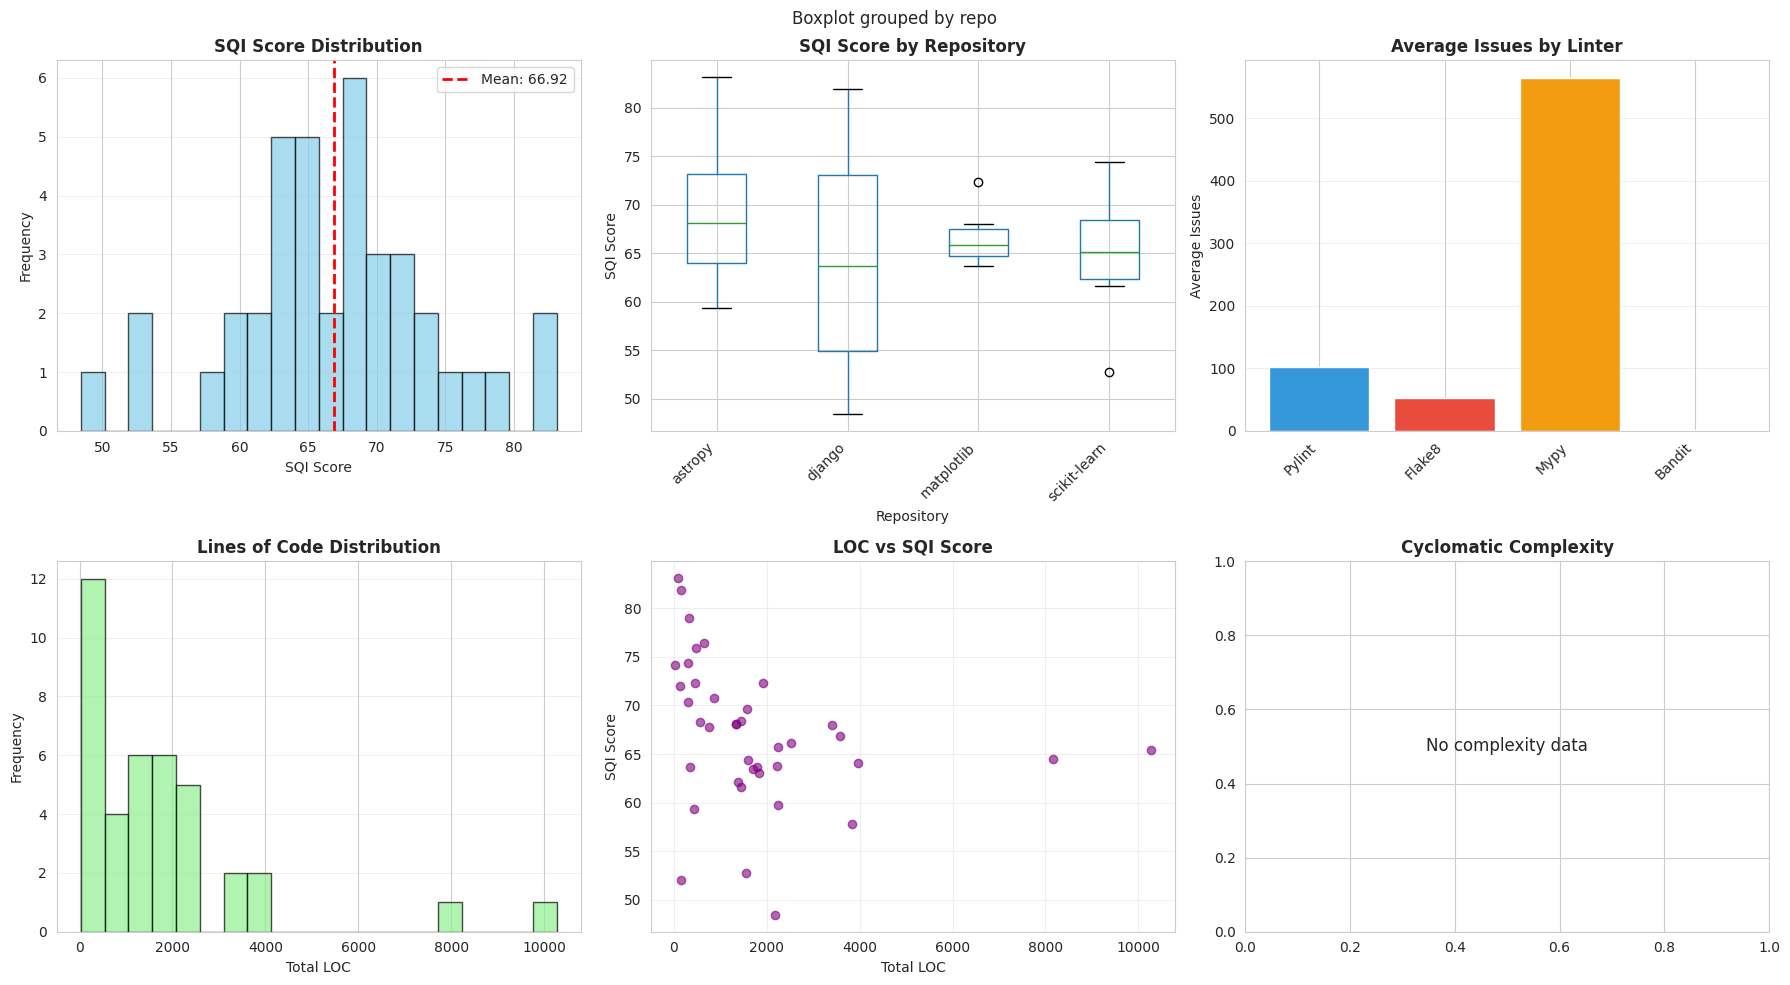

In [139]:
# Static analysis visualizations
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# 1. SQI Score distribution
axes[0, 0].hist(static_df['static_sqi_score'], bins=20, color='skyblue', edgecolor='black', alpha=0.7)
axes[0, 0].axvline(static_df['static_sqi_score'].mean(), color='red', linestyle='--', 
                   linewidth=2, label=f'Mean: {static_df["static_sqi_score"].mean():.2f}')
axes[0, 0].set_title('SQI Score Distribution', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('SQI Score')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].legend()
axes[0, 0].grid(axis='y', alpha=0.3)

# 2. SQI Score by repository
static_df.boxplot(column='static_sqi_score', by='repo', ax=axes[0, 1])
axes[0, 1].set_title('SQI Score by Repository', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Repository')
axes[0, 1].set_ylabel('SQI Score')
plt.sca(axes[0, 1])
plt.xticks(rotation=45, ha='right')

# 3. Linter issues comparison
linter_cols = ['pylint_issues', 'flake8_issues', 'mypy_errors', 'bandit_issues']
linter_means = static_df[linter_cols].mean()
axes[0, 2].bar(range(len(linter_means)), linter_means.values, 
               color=['#3498db', '#e74c3c', '#f39c12', '#9b59b6'])
axes[0, 2].set_xticks(range(len(linter_means)))
axes[0, 2].set_xticklabels(['Pylint', 'Flake8', 'Mypy', 'Bandit'], rotation=45, ha='right')
axes[0, 2].set_title('Average Issues by Linter', fontsize=12, fontweight='bold')
axes[0, 2].set_ylabel('Average Issues')
axes[0, 2].grid(axis='y', alpha=0.3)

# 4. LOC distribution
axes[1, 0].hist(static_df['static_total_loc'], bins=20, color='lightgreen', edgecolor='black', alpha=0.7)
axes[1, 0].set_title('Lines of Code Distribution', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Total LOC')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].grid(axis='y', alpha=0.3)

# 5. Correlation: LOC vs SQI Score
axes[1, 1].scatter(static_df['static_total_loc'], static_df['static_sqi_score'], 
                   alpha=0.6, color='purple')
axes[1, 1].set_title('LOC vs SQI Score', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Total LOC')
axes[1, 1].set_ylabel('SQI Score')
axes[1, 1].grid(alpha=0.3)

# 6. Radon complexity
if static_df['radon_avg_complexity'].notna().any():
    axes[1, 2].hist(static_df['radon_avg_complexity'].dropna(), bins=15, 
                    color='orange', edgecolor='black', alpha=0.7)
    axes[1, 2].set_title('Cyclomatic Complexity Distribution', fontsize=12, fontweight='bold')
    axes[1, 2].set_xlabel('Average Complexity')
    axes[1, 2].set_ylabel('Frequency')
    axes[1, 2].grid(axis='y', alpha=0.3)
else:
    axes[1, 2].text(0.5, 0.5, 'No complexity data', ha='center', va='center', fontsize=12)
    axes[1, 2].set_title('Cyclomatic Complexity', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

TOP 20 MOST COMMON ISSUES
flake8          E501                                      1147
pylint          invalid-name                               578
flake8          E231                                       518
pylint          consider-using-f-string                    515
pylint          protected-access                           379
pylint          missing-function-docstring                 255
flake8          W504                                       224
pylint          no-else-return                             209
pylint          attribute-defined-outside-init             189
pylint          too-many-arguments                         178
pylint          too-many-positional-arguments              154
flake8          E226                                       134
pylint          unused-argument                            127
pylint          too-many-locals                            125
pylint          too-many-branches                          110
pylint          no-member    

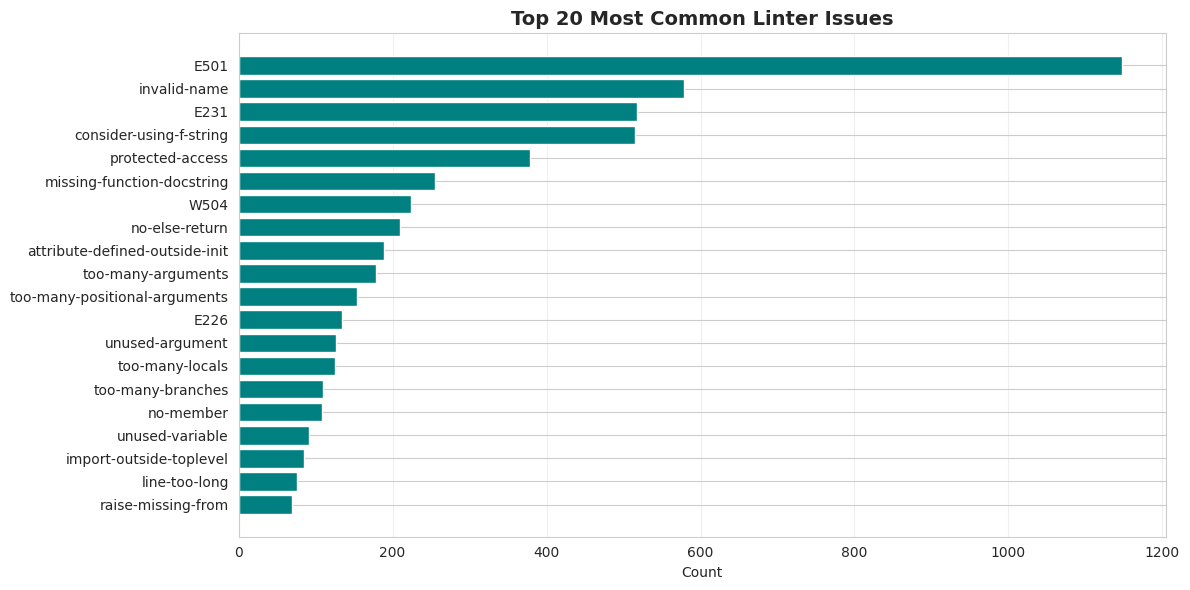

In [10]:
# Detailed linter issue breakdown
def extract_linter_issues(results):
    """Extract all linter issues with details."""
    issues = []
    
    for r in results:
        if not r.get('success') or 'static' not in r:
            continue
        
        instance_id = r['instance_id']
        analyzers = r.get('static', {}).get('analyzers', {})
        
        # Pylint issues
        pylint = analyzers.get('pylint', {})
        if 'by_file' in pylint:
            for file, file_issues in pylint['by_file'].items():
                for issue in file_issues:
                    issues.append({
                        'instance_id': instance_id,
                        'tool': 'pylint',
                        'type': issue.get('type'),
                        'symbol': issue.get('symbol'),
                        'message': issue.get('message'),
                        'severity': issue.get('type')
                    })
        
        # Flake8 issues
        flake8 = analyzers.get('flake8', {})
        for issue in flake8.get('issues', []):
            issues.append({
                'instance_id': instance_id,
                'tool': 'flake8',
                'type': issue.get('code'),
                'symbol': issue.get('code'),
                'message': issue.get('message'),
                'severity': 'warning'
            })
        
        # Bandit issues
        bandit = analyzers.get('bandit', {})
        for issue in bandit.get('issues', []):
            issues.append({
                'instance_id': instance_id,
                'tool': 'bandit',
                'type': issue.get('test_id'),
                'symbol': issue.get('test_id'),
                'message': issue.get('issue_text'),
                'severity': issue.get('issue_severity', 'unknown').lower()
            })
    
    return pd.DataFrame(issues)

issues_df = extract_linter_issues(results)

if len(issues_df) > 0:
    print("=" * 80)
    print("TOP 20 MOST COMMON ISSUES")
    print("=" * 80)
    top_issues = issues_df.groupby(['tool', 'symbol']).size().sort_values(ascending=False).head(20)
    for (tool, symbol), count in top_issues.items():
        print(f"{tool:15} {symbol:40} {count:5d}")
    
    # Visualize top issues
    plt.figure(figsize=(12, 6))
    top_20 = issues_df['symbol'].value_counts().head(20)
    plt.barh(range(len(top_20)), top_20.values, color='teal')
    plt.yticks(range(len(top_20)), top_20.index)
    plt.xlabel('Count')
    plt.title('Top 20 Most Common Linter Issues', fontsize=14, fontweight='bold')
    plt.gca().invert_yaxis()
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("No detailed issue data available")

## 4. Fuzzing & Testing Analysis

Analysis of test generation, coverage, and fuzzing results.

In [11]:
# Filter to successful runs with fuzzing data
fuzz_df = df_filtered[df_filtered['success'] & df_filtered['tests_generated'].notna()].copy()

print("=" * 80)
print("FUZZING & TESTING SUMMARY")
print("=" * 80)
print(f"Instances with fuzzing data: {len(fuzz_df)}")
print(f"\nFuzzing pass rate: {fuzz_df['fuzzing_passed'].mean()*100:.1f}%")
print(f"Tests pass rate: {fuzz_df['tests_passed'].mean()*100:.1f}%")

print(f"\nTest Generation:")
print(f"  Average tests generated: {fuzz_df['tests_generated'].mean():.2f}")
print(f"  Total tests generated: {fuzz_df['tests_generated'].sum():.0f}")

print(f"\nCoverage Statistics:")
print(f"  Baseline coverage (mean): {fuzz_df['baseline_coverage'].mean():.2f}%")
print(f"  Combined coverage (mean): {fuzz_df['combined_coverage'].mean():.2f}%")
print(f"  Average improvement: {fuzz_df['coverage_improvement'].mean():.2f}%")

print(f"\nDivergence Detection:")
print(f"  Instances with divergences: {fuzz_df['divergences_detected'].sum()}")
print(f"  Total divergences found: {fuzz_df['divergence_count'].sum():.0f}")

print(f"\nBaseline Tests:")
print(f"  Average test count: {fuzz_df['baseline_test_count'].mean():.0f}")
print(f"  Average fail-to-pass: {fuzz_df['fail_to_pass'].mean():.1f}")
print(f"  Average pass-to-pass: {fuzz_df['pass_to_pass'].mean():.1f}")

FUZZING & TESTING SUMMARY
Instances with fuzzing data: 37

Fuzzing pass rate: 89.2%
Tests pass rate: 100.0%

Test Generation:
  Average tests generated: 3.27
  Total tests generated: 121

Coverage Statistics:
  Baseline coverage (mean): 90.51%
  Combined coverage (mean): 87.80%
  Average improvement: -2.70%

Divergence Detection:
  Instances with divergences: 0
  Total divergences found: 0

Baseline Tests:
  Average test count: 144
  Average fail-to-pass: 1.9
  Average pass-to-pass: 142.3


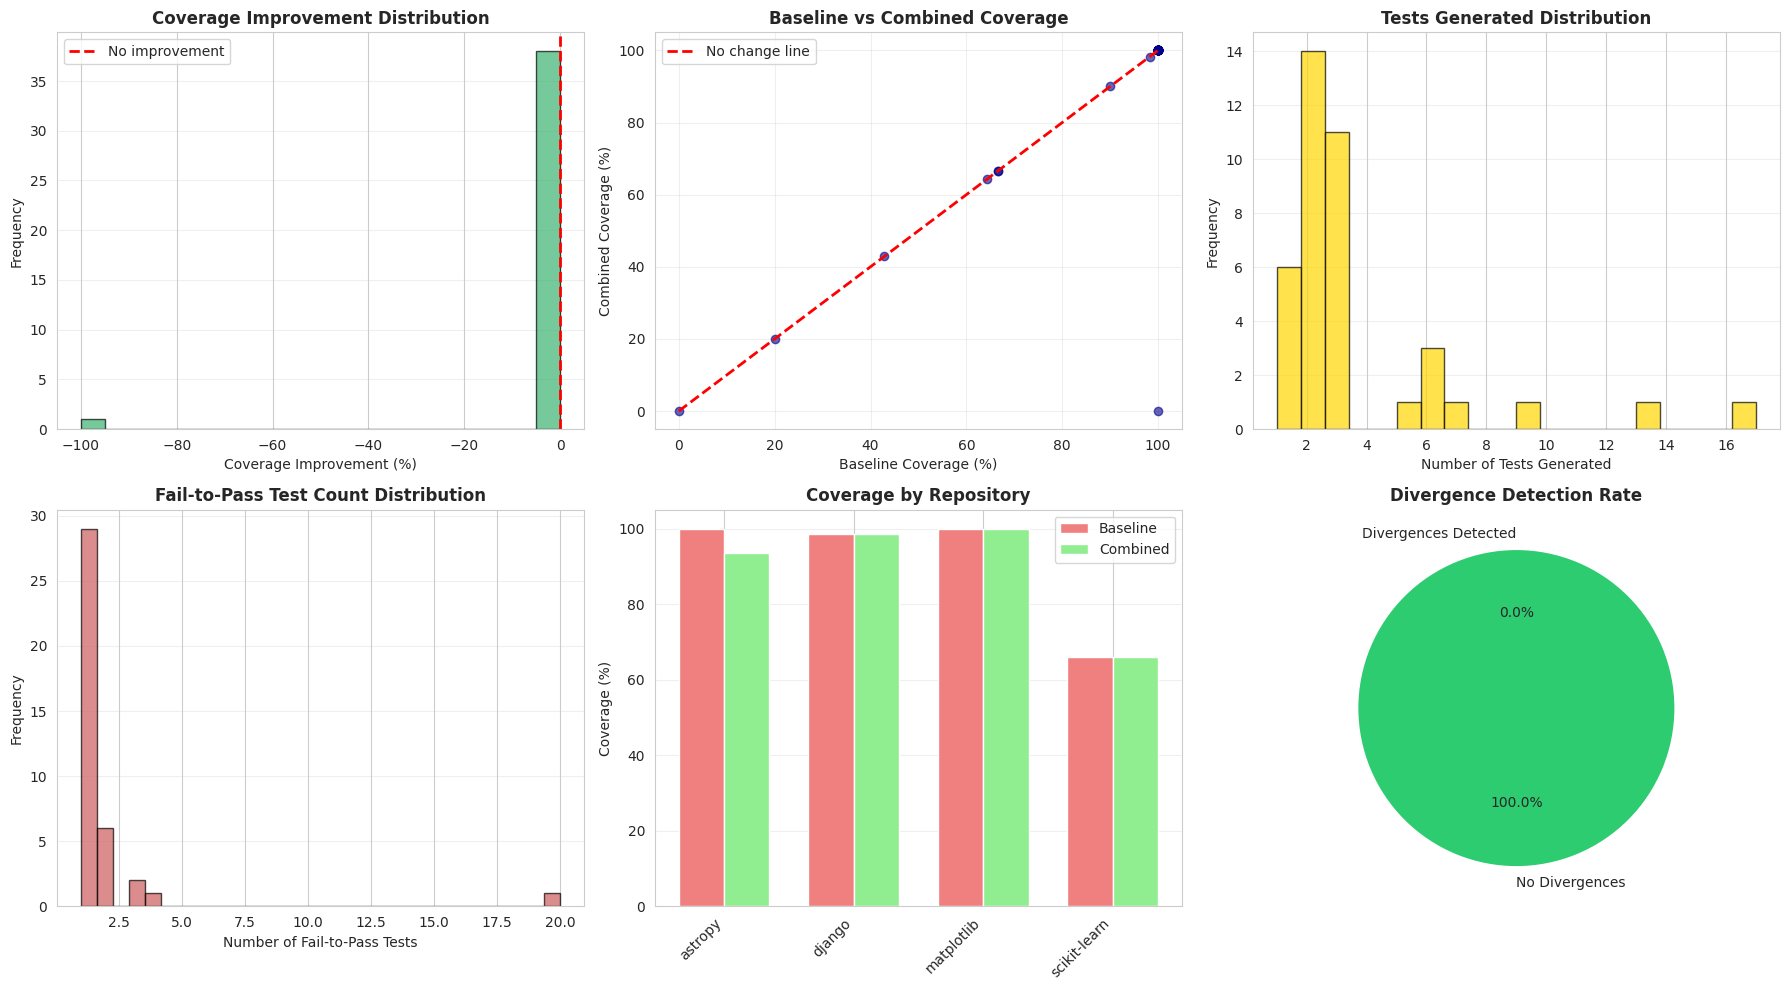

In [142]:
# Fuzzing visualizations
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# 1. Coverage improvement distribution
axes[0, 0].hist(fuzz_df['coverage_improvement'], bins=20, color='mediumseagreen', 
                edgecolor='black', alpha=0.7)
axes[0, 0].axvline(0, color='red', linestyle='--', linewidth=2, label='No improvement')
axes[0, 0].set_title('Coverage Improvement Distribution', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Coverage Improvement (%)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].legend()
axes[0, 0].grid(axis='y', alpha=0.3)

# 2. Baseline vs Combined coverage
axes[0, 1].scatter(fuzz_df['baseline_coverage'], fuzz_df['combined_coverage'], 
                   alpha=0.6, color='darkblue')
axes[0, 1].plot([0, 100], [0, 100], 'r--', linewidth=2, label='No change line')
axes[0, 1].set_title('Baseline vs Combined Coverage', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Baseline Coverage (%)')
axes[0, 1].set_ylabel('Combined Coverage (%)')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# 3. Tests generated distribution
axes[0, 2].hist(fuzz_df['tests_generated'], bins=20, color='gold', edgecolor='black', alpha=0.7)
axes[0, 2].set_title('Tests Generated Distribution', fontsize=12, fontweight='bold')
axes[0, 2].set_xlabel('Number of Tests Generated')
axes[0, 2].set_ylabel('Frequency')
axes[0, 2].grid(axis='y', alpha=0.3)

# 4. Fail-to-pass tests
axes[1, 0].hist(fuzz_df['fail_to_pass'], bins=30, color='indianred', edgecolor='black', alpha=0.7)
axes[1, 0].set_title('Fail-to-Pass Test Count Distribution', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Number of Fail-to-Pass Tests')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].grid(axis='y', alpha=0.3)

# 5. Coverage by repository
coverage_by_repo = fuzz_df.groupby('repo')[['baseline_coverage', 'combined_coverage']].mean()
x = np.arange(len(coverage_by_repo))
width = 0.35
axes[1, 1].bar(x - width/2, coverage_by_repo['baseline_coverage'], width, 
               label='Baseline', color='lightcoral')
axes[1, 1].bar(x + width/2, coverage_by_repo['combined_coverage'], width, 
               label='Combined', color='lightgreen')
axes[1, 1].set_xticks(x)
axes[1, 1].set_xticklabels(coverage_by_repo.index, rotation=45, ha='right')
axes[1, 1].set_title('Coverage by Repository', fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('Coverage (%)')
axes[1, 1].legend()
axes[1, 1].grid(axis='y', alpha=0.3)

# 6. Divergences detected
divergence_data = [
    fuzz_df['divergences_detected'].sum(),
    len(fuzz_df) - fuzz_df['divergences_detected'].sum()
]
axes[1, 2].pie(divergence_data, labels=['Divergences Detected', 'No Divergences'], 
               autopct='%1.1f%%', colors=['#e74c3c', '#2ecc71'], startangle=90)
axes[1, 2].set_title('Divergence Detection Rate', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

## 4.5. Edge Cases & Error Detection Analysis

Deep dive into what edge cases the fuzzing tests discover and what errors they trigger.

In [12]:
# Extract fuzzing test errors and edge cases (ONLY from baseline-passing instances)
import re

def extract_fuzzing_errors(results, filtered_instance_ids):
    """Extract detailed error information from fuzzing test failures."""
    error_data = []
    
    for r in results:
        # Only process instances that passed baseline tests
        if r.get('instance_id') not in filtered_instance_ids:
            continue
        if not r.get('success') or 'fuzzing' not in r:
            continue
        
        instance_id = r['instance_id']
        repo = r.get('repo', '').split('/')[-1]
        fuzz = r['fuzzing']
        
        if 'details' not in fuzz or 'fuzzing_tests' not in fuzz['details']:
            continue
        
        fuzz_tests = fuzz['details']['fuzzing_tests']
        
        # Only process if fuzzing failed
        if not fuzz_tests.get('passed', True):
            stdout = fuzz_tests.get('stdout', '')
            stderr = fuzz_tests.get('stderr', '')
            combined = stdout + '\n' + stderr
            
            # Extract error types
            errors = []
            
            # ImportError
            for match in re.findall(r'ImportError: (.+)', combined):
                errors.append({'type': 'ImportError', 'message': match[:150]})
            
            # AttributeError
            for match in re.findall(r'AttributeError: (.+)', combined):
                errors.append({'type': 'AttributeError', 'message': match[:150]})
            
            # TypeError
            for match in re.findall(r'TypeError: (.+)', combined):
                errors.append({'type': 'TypeError', 'message': match[:150]})
            
            # ValueError
            for match in re.findall(r'ValueError: (.+)', combined):
                errors.append({'type': 'ValueError', 'message': match[:150]})
            
            # IndexError
            for match in re.findall(r'IndexError: (.+)', combined):
                errors.append({'type': 'IndexError', 'message': match[:150]})
            
            # KeyError
            for match in re.findall(r'KeyError: (.+)', combined):
                errors.append({'type': 'KeyError', 'message': match[:150]})
            
            # AssertionError
            for match in re.findall(r'AssertionError: (.+)', combined):
                errors.append({'type': 'AssertionError', 'message': match[:150]})
            
            # ZeroDivisionError
            for match in re.findall(r'ZeroDivisionError: (.+)', combined):
                errors.append({'type': 'ZeroDivisionError', 'message': match[:150]})
            
            # OverflowError
            for match in re.findall(r'OverflowError: (.+)', combined):
                errors.append({'type': 'OverflowError', 'message': match[:150]})
            
            # RecursionError
            for match in re.findall(r'RecursionError: (.+)', combined):
                errors.append({'type': 'RecursionError', 'message': match[:150]})
            
            # Hypothesis-specific failures
            for match in re.findall(r'Falsifying example: (.+)', combined):
                errors.append({'type': 'HypothesisFalsify', 'message': match[:150]})
            
            for match in re.findall(r'hypothesis.errors.(\w+): (.+)', combined):
                errors.append({'type': f'Hypothesis{match[0]}', 'message': match[1][:150]})
            
            # Extract test names that failed
            failed_tests = list(set(re.findall(r'FAILED (test_[\w]+)', combined)))
            
            if errors or failed_tests:
                error_data.append({
                    'instance_id': instance_id,
                    'repo': repo,
                    'tests_generated': fuzz.get('tests_generated', 0),
                    'failed_tests': failed_tests,
                    'errors': errors,
                    'error_count': len(errors),
                    'returncode': fuzz_tests.get('returncode', 0)
                })
    
    return error_data

# Extract errors
fuzzing_errors = extract_fuzzing_errors(results, set(df_filtered['instance_id'].tolist()))

print("=" * 80)
print("FUZZING ERROR & EDGE CASE DETECTION")
print("=" * 80)
print(f"Total instances with fuzzing errors: {len(fuzzing_errors)}")

# Count error types
error_type_counts = {}
for err_instance in fuzzing_errors:
    for error in err_instance['errors']:
        etype = error['type']
        error_type_counts[etype] = error_type_counts.get(etype, 0) + 1

print(f"\nError Types Detected:")
for etype, count in sorted(error_type_counts.items(), key=lambda x: x[1], reverse=True):
    print(f"  {etype:30s}: {count:3d} occurrences")

# Repository breakdown
print(f"\nErrors by Repository:")
repo_error_counts = {}
for err_instance in fuzzing_errors:
    repo = err_instance['repo']
    repo_error_counts[repo] = repo_error_counts.get(repo, 0) + err_instance['error_count']

for repo, count in sorted(repo_error_counts.items(), key=lambda x: x[1], reverse=True):
    instances = len([e for e in fuzzing_errors if e['repo'] == repo])
    print(f"  {repo:20s}: {count:3d} errors across {instances} instances")

print(f"\nTotal Errors Found: {sum(error_type_counts.values())}")

FUZZING ERROR & EDGE CASE DETECTION
Total instances with fuzzing errors: 8

Error Types Detected:
  HypothesisInvalidArgument     :   1 occurrences

Errors by Repository:
  astropy             :   1 errors across 3 instances
  django              :   0 errors across 2 instances
  matplotlib          :   0 errors across 3 instances

Total Errors Found: 1


In [144]:
# Show specific error examples
print("=" * 80)
print("SPECIFIC ERROR EXAMPLES")
print("=" * 80)

# Group errors by type
errors_by_type = {}
for err_instance in fuzzing_errors:
    for error in err_instance['errors']:
        etype = error['type']
        if etype not in errors_by_type:
            errors_by_type[etype] = []
        errors_by_type[etype].append({
            'instance': err_instance['instance_id'],
            'repo': err_instance['repo'],
            'message': error['message']
        })

# Show examples for each error type
for etype in sorted(errors_by_type.keys()):
    examples = errors_by_type[etype]
    print(f"\n{etype} ({len(examples)} total):")
    
    # Show up to 3 unique examples
    seen_messages = set()
    shown = 0
    for ex in examples:
        if ex['message'] not in seen_messages and shown < 3:
            print(f"  [{ex['repo']}] {ex['instance']}:")
            print(f"    {ex['message']}")
            seen_messages.add(ex['message'])
            shown += 1

# Show instances with most errors
print(f"\n{'='*80}")
print("INSTANCES WITH MOST ERRORS")
print('='*80)
sorted_instances = sorted(fuzzing_errors, key=lambda x: x['error_count'], reverse=True)
for i, inst in enumerate(sorted_instances[:10]):
    print(f"{i+1}. {inst['instance_id']} ({inst['repo']}):")
    print(f"   {inst['error_count']} errors, {inst['tests_generated']} tests generated")
    print(f"   Error types: {', '.join(set([e['type'] for e in inst['errors']]))}")
    if inst['failed_tests']:
        print(f"   Failed tests: {', '.join(inst['failed_tests'][:3])}")

SPECIFIC ERROR EXAMPLES

HypothesisInvalidArgument (1 total):
  [astropy] astropy__astropy-14539:
    Using `@settings` on a test without `@gi...

INSTANCES WITH MOST ERRORS
1. astropy__astropy-14539 (astropy):
   1 errors, 2 tests generated
   Error types: HypothesisInvalidArgument
2. astropy__astropy-8707 (astropy):
   0 errors, 13 tests generated
   Error types: 
   Failed tests: test_fuzzing_generated
3. astropy__astropy-8872 (astropy):
   0 errors, 3 tests generated
   Error types: 
   Failed tests: test_fuzzing_generated
4. django__django-10554 (django):
   0 errors, 3 tests generated
   Error types: 
   Failed tests: test_fuzzing_generated
5. django__django-10880 (django):
   0 errors, 3 tests generated
   Error types: 
   Failed tests: test_fuzzing_generated
6. django__django-11087 (django):
   0 errors, 9 tests generated
   Error types: 
   Failed tests: test_fuzzing_generated
7. django__django-11095 (django):
   0 errors, 6 tests generated
   Error types: 
   Failed tests: te

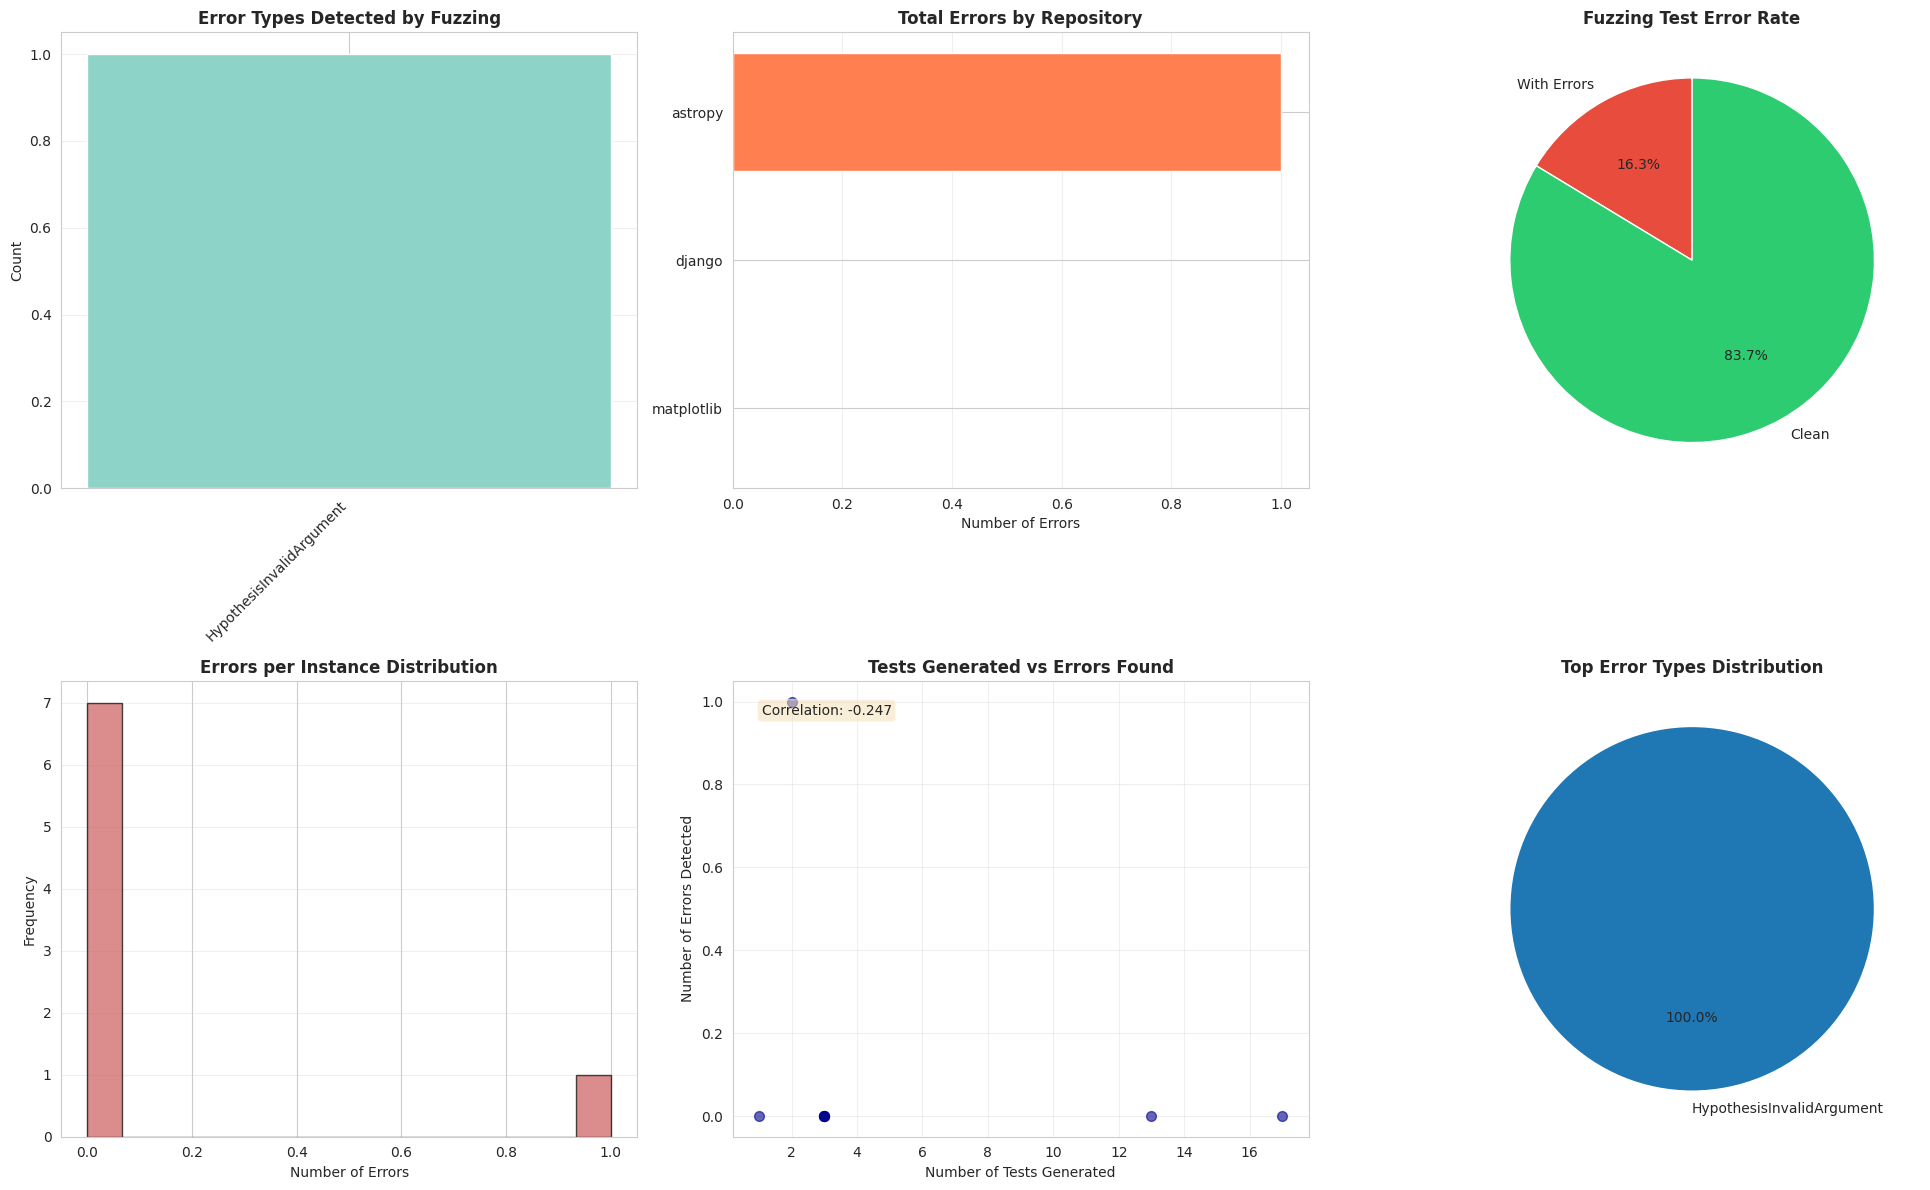

In [14]:
# Error detection visualizations
fig, axes = plt.subplots(2, 3, figsize=(20, 12))

# 1. Error type distribution
if error_type_counts:
    error_types = list(error_type_counts.keys())
    error_counts = list(error_type_counts.values())
    colors_palette = plt.cm.Set3(range(len(error_types)))
    
    axes[0, 0].bar(range(len(error_types)), error_counts, color=colors_palette)
    axes[0, 0].set_xticks(range(len(error_types)))
    axes[0, 0].set_xticklabels(error_types, rotation=45, ha='right')
    axes[0, 0].set_title('Error Types Detected by Fuzzing', fontsize=12, fontweight='bold')
    axes[0, 0].set_ylabel('Count')
    axes[0, 0].grid(axis='y', alpha=0.3)
else:
    axes[0, 0].text(0.5, 0.5, 'No errors detected', ha='center', va='center', fontsize=12)
    axes[0, 0].set_title('Error Types Detected', fontsize=12, fontweight='bold')

# 2. Errors by repository
if repo_error_counts:
    repos = list(repo_error_counts.keys())
    counts = list(repo_error_counts.values())
    
    axes[0, 1].barh(range(len(repos)), counts, color='coral')
    axes[0, 1].set_yticks(range(len(repos)))
    axes[0, 1].set_yticklabels(repos)
    axes[0, 1].set_title('Total Errors by Repository', fontsize=12, fontweight='bold')
    axes[0, 1].set_xlabel('Number of Errors')
    axes[0, 1].invert_yaxis()
    axes[0, 1].grid(axis='x', alpha=0.3)
else:
    axes[0, 1].text(0.5, 0.5, 'No errors detected', ha='center', va='center', fontsize=12)
    axes[0, 1].set_title('Errors by Repository', fontsize=12, fontweight='bold')

# 3. Error rate: instances with/without errors
total_fuzz_instances = len([r for r in results if r.get('success') and 'fuzzing' in r])
error_instances = len(fuzzing_errors)
clean_instances = total_fuzz_instances - error_instances

axes[0, 2].pie([error_instances, clean_instances], 
               labels=['With Errors', 'Clean'], 
               autopct='%1.1f%%',
               colors=['#e74c3c', '#2ecc71'],
               startangle=90)
axes[0, 2].set_title('Fuzzing Test Error Rate', fontsize=12, fontweight='bold')

# 4. Errors per instance distribution
if fuzzing_errors:
    error_counts_per_inst = [e['error_count'] for e in fuzzing_errors]
    axes[1, 0].hist(error_counts_per_inst, bins=15, color='indianred', edgecolor='black', alpha=0.7)
    axes[1, 0].set_title('Errors per Instance Distribution', fontsize=12, fontweight='bold')
    axes[1, 0].set_xlabel('Number of Errors')
    axes[1, 0].set_ylabel('Frequency')
    axes[1, 0].grid(axis='y', alpha=0.3)
else:
    axes[1, 0].text(0.5, 0.5, 'No errors detected', ha='center', va='center', fontsize=12)
    axes[1, 0].set_title('Errors per Instance', fontsize=12, fontweight='bold')

# 5. Tests generated vs Errors (do more tests find more edge cases?)
if fuzzing_errors:
    tests_gen = [e['tests_generated'] for e in fuzzing_errors]
    errors_found = [e['error_count'] for e in fuzzing_errors]
    
    axes[1, 1].scatter(tests_gen, errors_found, alpha=0.6, color='darkblue', s=50)
    axes[1, 1].set_title('Tests Generated vs Errors Found', fontsize=12, fontweight='bold')
    axes[1, 1].set_xlabel('Number of Tests Generated')
    axes[1, 1].set_ylabel('Number of Errors Detected')
    axes[1, 1].grid(alpha=0.3)
    
    # Calculate correlation
    if len(tests_gen) > 1:
        corr = np.corrcoef(tests_gen, errors_found)[0, 1]
        axes[1, 1].text(0.05, 0.95, f'Correlation: {corr:.3f}', 
                        transform=axes[1, 1].transAxes, fontsize=10,
                        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
else:
    axes[1, 1].text(0.5, 0.5, 'No errors detected', ha='center', va='center', fontsize=12)
    axes[1, 1].set_title('Tests vs Errors', fontsize=12, fontweight='bold')

# 6. Top error types (pie chart)
if error_type_counts:
    top_5_types = dict(sorted(error_type_counts.items(), key=lambda x: x[1], reverse=True)[:5])
    others_count = sum(error_type_counts.values()) - sum(top_5_types.values())
    
    if others_count > 0:
        top_5_types['Others'] = others_count
    
    axes[1, 2].pie(top_5_types.values(), labels=top_5_types.keys(), 
                   autopct='%1.1f%%', startangle=90)
    axes[1, 2].set_title('Top Error Types Distribution', fontsize=12, fontweight='bold')
else:
    axes[1, 2].text(0.5, 0.5, 'No errors detected', ha='center', va='center', fontsize=12)
    axes[1, 2].set_title('Top Error Types', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

## 4.6. Raw Fuzzing Error Output Viewer

View the actual stdout/stderr from failed fuzzing tests to see the original errors.

In [15]:
# Extract and display raw fuzzing test output for failed instances
def get_raw_fuzzing_output(results, filtered_instance_ids):
    """Get the raw stdout/stderr from fuzzing test failures."""
    raw_outputs = []
    
    for r in results:
        # Only process instances that passed baseline tests
        if r.get('instance_id') not in filtered_instance_ids:
            continue
        if not r.get('success') or 'fuzzing' not in r:
            continue
        
        instance_id = r['instance_id']
        repo = r.get('repo', '').split('/')[-1]
        fuzz = r['fuzzing']
        
        if 'details' not in fuzz or 'fuzzing_tests' not in fuzz['details']:
            continue
        
        fuzz_tests = fuzz['details']['fuzzing_tests']
        
        # Only process if fuzzing failed
        if not fuzz_tests.get('passed', True):
            raw_outputs.append({
                'instance_id': instance_id,
                'repo': repo,
                'tests_generated': fuzz.get('tests_generated', 0),
                'returncode': fuzz_tests.get('returncode', 0),
                'stdout': fuzz_tests.get('stdout', ''),
                'stderr': fuzz_tests.get('stderr', '')
            })
    
    return raw_outputs

# Get raw outputs
raw_outputs = get_raw_fuzzing_output(results, set(df_filtered['instance_id'].tolist()))

print("=" * 80)
print("RAW FUZZING ERROR OUTPUT")
print("=" * 80)
print(f"Found {len(raw_outputs)} instances with fuzzing test failures\n")

# Interactive viewer - select which instance to view
if raw_outputs:
    print("Available instances with fuzzing failures:")
    for i, output in enumerate(raw_outputs):
        print(f"  {i}: {output['instance_id']} ({output['repo']}) - {output['tests_generated']} tests generated, returncode: {output['returncode']}")
    
    print("\n" + "=" * 80)
    print("To view the raw output for a specific instance, set the variable below:")
    print("Example: view_instance = 0  # View the first instance")
    print("=" * 80)
else:
    print("No fuzzing failures found in baseline-passing instances")

RAW FUZZING ERROR OUTPUT
Found 18 instances with fuzzing test failures

Available instances with fuzzing failures:
  0: astropy__astropy-13977 (astropy) - 5 tests generated, returncode: 2
  1: astropy__astropy-14096 (astropy) - 2 tests generated, returncode: 2
  2: astropy__astropy-14309 (astropy) - 2 tests generated, returncode: 2
  3: astropy__astropy-14365 (astropy) - 6 tests generated, returncode: 2
  4: astropy__astropy-14369 (astropy) - 7 tests generated, returncode: 2
  5: astropy__astropy-14508 (astropy) - 3 tests generated, returncode: 2
  6: astropy__astropy-14539 (astropy) - 2 tests generated, returncode: 1
  7: astropy__astropy-14995 (astropy) - 3 tests generated, returncode: 1
  8: astropy__astropy-8707 (astropy) - 13 tests generated, returncode: 1
  9: astropy__astropy-8872 (astropy) - 3 tests generated, returncode: 1
  10: django__django-10554 (django) - 3 tests generated, returncode: 1
  11: django__django-10880 (django) - 3 tests generated, returncode: 1
  12: django__

In [158]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [160]:
# Create a summary list of all original errors found in fuzzing output
print("=" * 80)
print("ORIGINAL ERRORS LIST - All Failed Fuzzing Instances")
print("=" * 80)

all_errors_summary = []

for output in raw_outputs:
    combined = output['stdout'] + '\n' + output['stderr']
    
    # Extract all Python exception lines (lines that end with "Error:")
    import re
    error_lines = re.findall(r'^.*Error:.*$', combined, re.MULTILINE)
    
    # Also extract FAILED test lines
    failed_lines = re.findall(r'^FAILED.*$', combined, re.MULTILINE)
    
    all_errors_summary.append({
        'instance_id': output['instance_id'],
        'repo': output['repo'],
        'tests_generated': output['tests_generated'],
        'error_lines': list(set(error_lines))[:10],  # Unique errors, max 10
        'failed_lines': list(set(failed_lines))[:5]   # Unique failures, max 5
    })

# Display summary
for i, summary in enumerate(all_errors_summary):
    print(f"\n{i}. {summary['instance_id']} ({summary['repo']}) - {summary['tests_generated']} tests")
    print("   " + "-" * 76)
    
    if summary['error_lines']:
        print("   Errors found:")
        for err in summary['error_lines']:  # Show first 5
            print(f"     • {err}")
    else:
        print("   No Python error messages found in output")
    
    if summary['failed_lines']:
        print("   Failed tests:")
        for fail in summary['failed_lines']:  # Show first 3
            print(f"     • {fail.strip()}")

print("\n" + "=" * 80)
print(f"Total: {len(all_errors_summary)} instances with fuzzing failures")
print("=" * 80)
print("\nTo see full output for any instance, use the interactive viewer cell above")
print("and set: view_instance = <number>")

ORIGINAL ERRORS LIST - All Failed Fuzzing Instances

0. astropy__astropy-13977 (astropy) - 5 tests
   ----------------------------------------------------------------------------
   No Python error messages found in output

1. astropy__astropy-14096 (astropy) - 2 tests
   ----------------------------------------------------------------------------
   No Python error messages found in output

2. astropy__astropy-14309 (astropy) - 2 tests
   ----------------------------------------------------------------------------
   No Python error messages found in output

3. astropy__astropy-14365 (astropy) - 6 tests
   ----------------------------------------------------------------------------
   No Python error messages found in output

4. astropy__astropy-14369 (astropy) - 7 tests
   ----------------------------------------------------------------------------
   No Python error messages found in output

5. astropy__astropy-14508 (astropy) - 3 tests
   -------------------------------------------

In [157]:
# Interactive viewer cell - run this to view specific instance output
# Set this variable to the instance number you want to view (from the list above)
view_instance = 0  # Change this number to view different instances

if raw_outputs and 0 <= view_instance < len(raw_outputs):
    output = raw_outputs[view_instance]
    
    print("=" * 80)
    print(f"INSTANCE: {output['instance_id']}")
    print(f"Repository: {output['repo']}")
    print(f"Tests Generated: {output['tests_generated']}")
    print(f"Return Code: {output['returncode']}")
    print("=" * 80)
    
    print("\n" + "=" * 80)
    print("STDOUT:")
    print("=" * 80)
    print(output['stdout'] if output['stdout'] else "(empty)")
    
    print("\n" + "=" * 80)
    print("STDERR:")
    print("=" * 80)
    print(output['stderr'] if output['stderr'] else "(empty)")
    
elif raw_outputs:
    print(f"Invalid instance number. Please choose between 0 and {len(raw_outputs)-1}")
else:
    print("No fuzzing failures available to view")

INSTANCE: astropy__astropy-13977
Repository: astropy
Tests Generated: 5
Return Code: 2

STDOUT:
   33     33     0%   4-126
astropy/visualization/wcsaxes/helpers.py                                             44     44     0%   7-204
astropy/visualization/wcsaxes/patches.py                                             46     46     0%   4-197
astropy/visualization/wcsaxes/tests/test_coordinate_helpers.py                       73     73     0%   3-114
astropy/visualization/wcsaxes/tests/test_display_world_coordinates.py                84     84     0%   2-158
astropy/visualization/wcsaxes/tests/test_formatter_locator.py                       219    219     0%   3-627
astropy/visualization/wcsaxes/tests/test_frame.py                                    93     93     0%   3-159
astropy/visualization/wcsaxes/tests/test_grid_paths.py                               14     14     0%   1-28
astropy/visualization/wcsaxes/tests/test_images.py                                  604    604     0%   2-1

In [ ]:
# Extract and display raw fuzzing test output for failed instances
def get_raw_fuzzing_output(results, filtered_instance_ids):
    """Get the raw stdout/stderr from fuzzing test failures."""
    raw_outputs = []
    
    for r in results:
        # Only process instances that passed baseline tests
        if r.get('instance_id') not in filtered_instance_ids:
            continue
        if not r.get('success') or 'fuzzing' not in r:
            continue
        
        instance_id = r['instance_id']
        repo = r.get('repo', '').split('/')[-1]
        fuzz = r['fuzzing']
        
        if 'details' not in fuzz or 'fuzzing_tests' not in fuzz['details']:
            continue
        
        fuzz_tests = fuzz['details']['fuzzing_tests']
        
        # Only process if fuzzing failed
        if not fuzz_tests.get('passed', True):
            raw_outputs.append({
                'instance_id': instance_id,
                'repo': repo,
                'tests_generated': fuzz.get('tests_generated', 0),
                'returncode': fuzz_tests.get('returncode', 0),
                'stdout': fuzz_tests.get('stdout', ''),
                'stderr': fuzz_tests.get('stderr', '')
            })
    
    return raw_outputs

# Get raw outputs
raw_outputs = get_raw_fuzzing_output(results, set(df_filtered['instance_id'].tolist()))

print("=" * 80)
print("RAW FUZZING ERROR OUTPUT")
print("=" * 80)
print(f"Found {len(raw_outputs)} instances with fuzzing test failures\n")

# Interactive viewer - select which instance to view
if raw_outputs:
    print("Available instances with fuzzing failures:")
    for i, output in enumerate(raw_outputs):
        print(f"  {i}: {output['instance_id']} ({output['repo']}) - {output['tests_generated']} tests generated, returncode: {output['returncode']}")
    
    print("\n" + "=" * 80)
    print("To view the raw output for a specific instance, set the variable below:")
    print("Example: view_instance = 0  # View the first instance")
    print("=" * 80)
else:
    print("No fuzzing failures found in baseline-passing instances")

## 5. Rules Engine Analysis

Analysis of rule-based findings and security issues.

In [147]:
# Filter to successful runs with rules data
rules_df = df_filtered[df_filtered['success'] & df_filtered['rules_total'].notna()].copy()

print("=" * 80)
print("RULES ENGINE SUMMARY")
print("=" * 80)
print(f"Instances with rules data: {len(rules_df)}")
print(f"\nRules pass rate: {rules_df['rules_passed'].mean()*100:.1f}%")

print(f"\nFindings Statistics:")
print(f"  Total findings: {rules_df['findings_count'].sum():.0f}")
print(f"  Average findings per instance: {rules_df['findings_count'].mean():.2f}")

print(f"\nFindings by Severity:")
print(f"  High: {rules_df['high_severity'].sum():.0f} ({rules_df['high_severity'].mean():.2f} per instance)")
print(f"  Medium: {rules_df['medium_severity'].sum():.0f} ({rules_df['medium_severity'].mean():.2f} per instance)")
print(f"  Low: {rules_df['low_severity'].sum():.0f} ({rules_df['low_severity'].mean():.2f} per instance)")

print(f"\nInstances with high-severity findings: {(rules_df['high_severity'] > 0).sum()}")

RULES ENGINE SUMMARY
Instances with rules data: 39

Rules pass rate: 100.0%

Findings Statistics:
  Total findings: 222
  Average findings per instance: 5.69

Findings by Severity:
  High: 0 (0.00 per instance)
  Medium: 222 (5.69 per instance)
  Low: 0 (0.00 per instance)

Instances with high-severity findings: 0


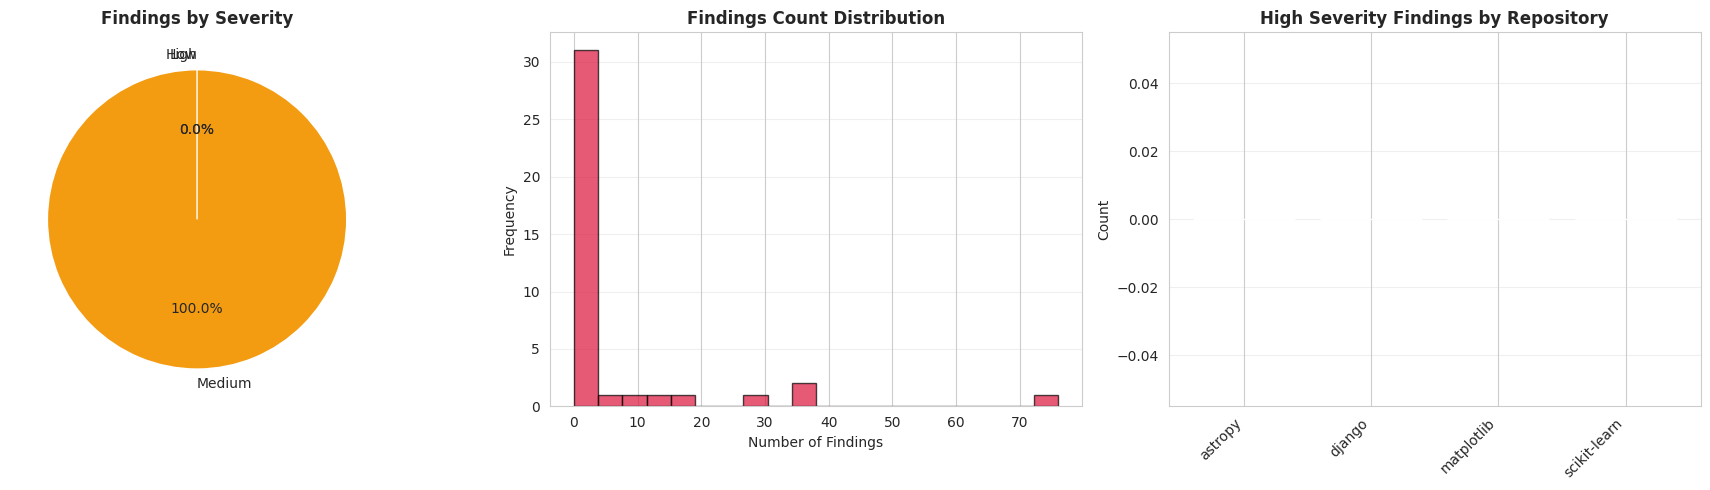

In [148]:
# Rules visualizations
if len(rules_df) > 0 and rules_df['findings_count'].sum() > 0:
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # 1. Severity distribution
    severity_totals = [
        rules_df['high_severity'].sum(),
        rules_df['medium_severity'].sum(),
        rules_df['low_severity'].sum()
    ]
    axes[0].pie(severity_totals, labels=['High', 'Medium', 'Low'], autopct='%1.1f%%',
                colors=['#e74c3c', '#f39c12', '#f1c40f'], startangle=90)
    axes[0].set_title('Findings by Severity', fontsize=12, fontweight='bold')
    
    # 2. Findings distribution
    axes[1].hist(rules_df['findings_count'], bins=20, color='crimson', edgecolor='black', alpha=0.7)
    axes[1].set_title('Findings Count Distribution', fontsize=12, fontweight='bold')
    axes[1].set_xlabel('Number of Findings')
    axes[1].set_ylabel('Frequency')
    axes[1].grid(axis='y', alpha=0.3)
    
    # 3. High severity by repo
    high_sev_by_repo = rules_df.groupby('repo')['high_severity'].sum()
    axes[2].bar(range(len(high_sev_by_repo)), high_sev_by_repo.values, color='darkred')
    axes[2].set_xticks(range(len(high_sev_by_repo)))
    axes[2].set_xticklabels(high_sev_by_repo.index, rotation=45, ha='right')
    axes[2].set_title('High Severity Findings by Repository', fontsize=12, fontweight='bold')
    axes[2].set_ylabel('Count')
    axes[2].grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
else:
    print("No rule findings to visualize")

## 6. Comparative Analysis

Cross-cutting comparisons and correlations.

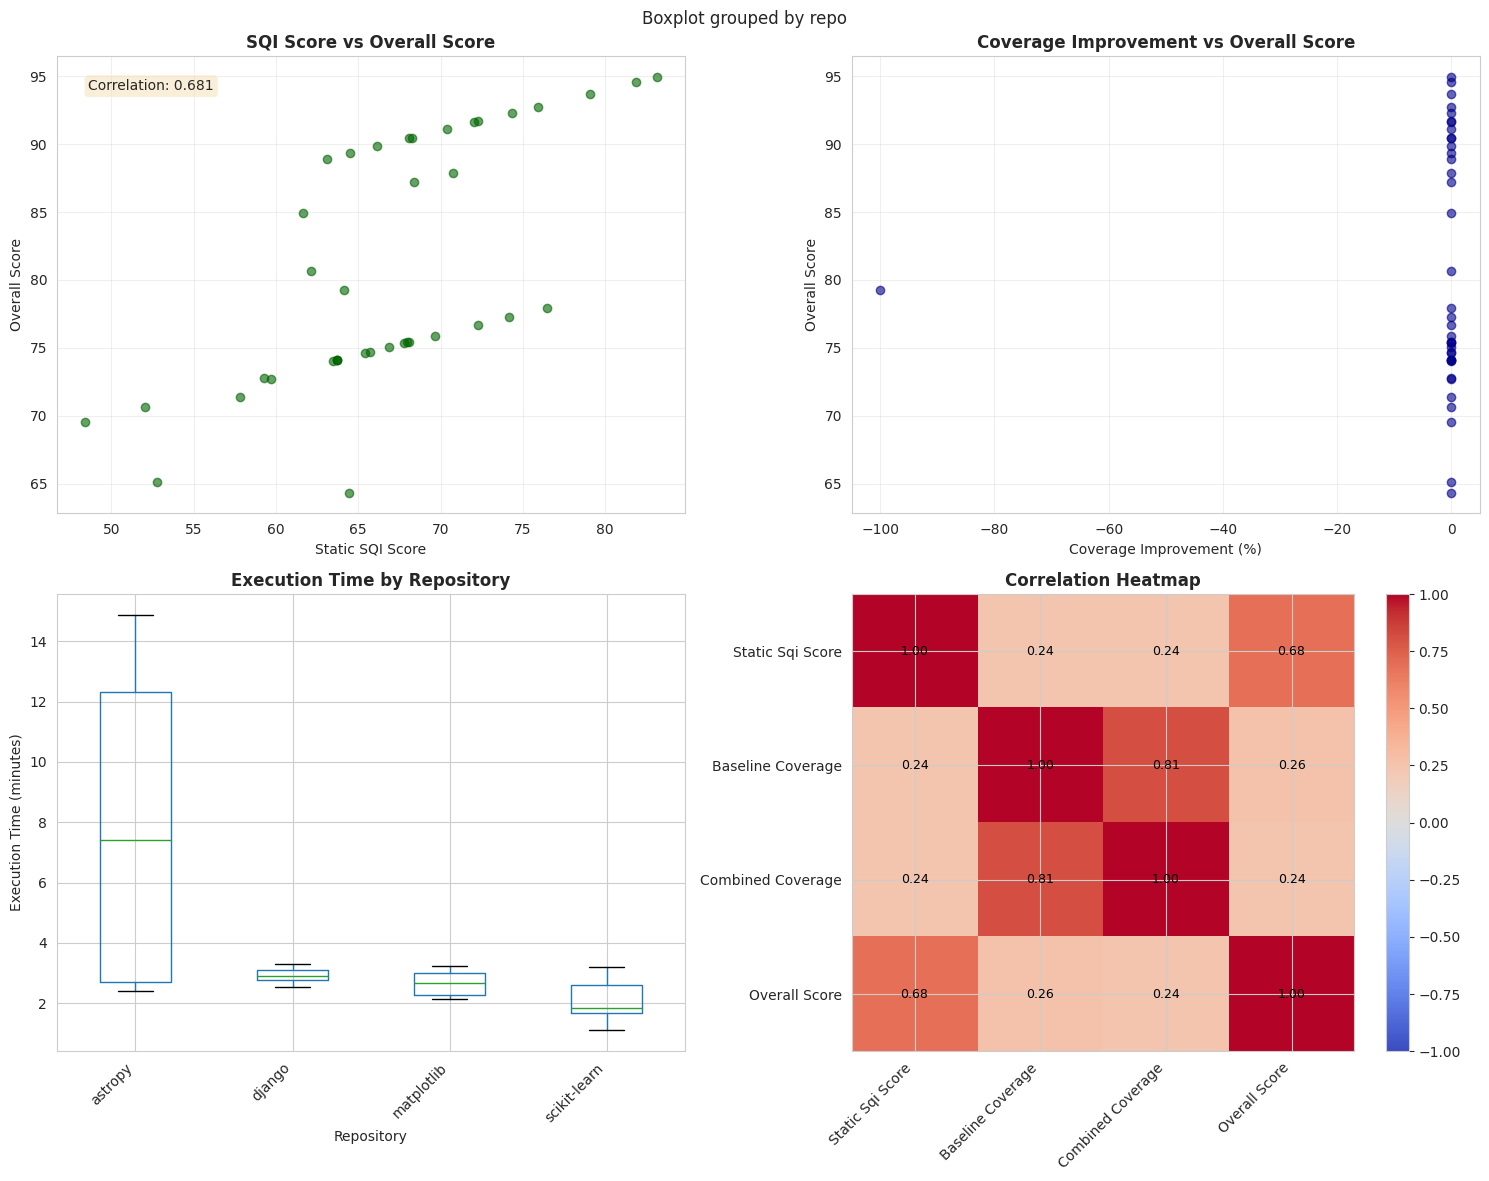

In [149]:
# Compare different metrics
successful_df = df_filtered[df_filtered['success'] == True].copy()

fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Overall score vs SQI score
valid_data = successful_df[successful_df['overall_score'].notna() & successful_df['static_sqi_score'].notna()]
if len(valid_data) > 0:
    axes[0, 0].scatter(valid_data['static_sqi_score'], valid_data['overall_score'], 
                       alpha=0.6, color='darkgreen')
    axes[0, 0].set_title('SQI Score vs Overall Score', fontsize=12, fontweight='bold')
    axes[0, 0].set_xlabel('Static SQI Score')
    axes[0, 0].set_ylabel('Overall Score')
    axes[0, 0].grid(alpha=0.3)
    
    # Add correlation
    if len(valid_data) > 1:
        corr = valid_data[['static_sqi_score', 'overall_score']].corr().iloc[0, 1]
        axes[0, 0].text(0.05, 0.95, f'Correlation: {corr:.3f}', 
                        transform=axes[0, 0].transAxes, fontsize=10,
                        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
else:
    axes[0, 0].text(0.5, 0.5, 'Insufficient data', ha='center', va='center', fontsize=12)
    axes[0, 0].set_title('SQI Score vs Overall Score', fontsize=12, fontweight='bold')

# 2. Coverage improvement vs Overall score
valid_data = successful_df[successful_df['overall_score'].notna() & successful_df['coverage_improvement'].notna()]
if len(valid_data) > 0:
    axes[0, 1].scatter(valid_data['coverage_improvement'], valid_data['overall_score'], 
                       alpha=0.6, color='darkblue')
    axes[0, 1].set_title('Coverage Improvement vs Overall Score', fontsize=12, fontweight='bold')
    axes[0, 1].set_xlabel('Coverage Improvement (%)')
    axes[0, 1].set_ylabel('Overall Score')
    axes[0, 1].grid(alpha=0.3)
else:
    axes[0, 1].text(0.5, 0.5, 'Insufficient data', ha='center', va='center', fontsize=12)
    axes[0, 1].set_title('Coverage Improvement vs Overall Score', fontsize=12, fontweight='bold')

# 3. Execution time by repository
successful_df.boxplot(column='elapsed_minutes', by='repo', ax=axes[1, 0])
axes[1, 0].set_title('Execution Time by Repository', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Repository')
axes[1, 0].set_ylabel('Execution Time (minutes)')
plt.sca(axes[1, 0])
plt.xticks(rotation=45, ha='right')

# 4. Score components heatmap
score_cols = ['static_sqi_score', 'baseline_coverage', 'combined_coverage', 'overall_score']
available_cols = [col for col in score_cols if col in successful_df.columns]
if len(available_cols) > 1:
    corr_matrix = successful_df[available_cols].corr()
    im = axes[1, 1].imshow(corr_matrix, cmap='coolwarm', aspect='auto', vmin=-1, vmax=1)
    axes[1, 1].set_xticks(range(len(available_cols)))
    axes[1, 1].set_yticks(range(len(available_cols)))
    axes[1, 1].set_xticklabels([col.replace('_', ' ').title() for col in available_cols], 
                                rotation=45, ha='right')
    axes[1, 1].set_yticklabels([col.replace('_', ' ').title() for col in available_cols])
    axes[1, 1].set_title('Correlation Heatmap', fontsize=12, fontweight='bold')
    
    # Add correlation values
    for i in range(len(available_cols)):
        for j in range(len(available_cols)):
            text = axes[1, 1].text(j, i, f'{corr_matrix.iloc[i, j]:.2f}',
                                   ha="center", va="center", color="black", fontsize=9)
    
    plt.colorbar(im, ax=axes[1, 1])
else:
    axes[1, 1].text(0.5, 0.5, 'Insufficient data', ha='center', va='center', fontsize=12)
    axes[1, 1].set_title('Correlation Heatmap', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

In [150]:
# Repository comparison table
print("=" * 80)
print("COMPREHENSIVE REPOSITORY COMPARISON")
print("=" * 80)

repo_comparison = successful_df.groupby('repo').agg({
    'instance_id': 'count',
    'overall_score': 'mean',
    'static_sqi_score': 'mean',
    'baseline_coverage': 'mean',
    'coverage_improvement': 'mean',
    'elapsed_minutes': 'mean',
    'pylint_issues': 'mean',
    'tests_generated': 'mean'
}).round(2)

repo_comparison.columns = ['Count', 'Avg Overall Score', 'Avg SQI', 'Avg Coverage', 
                           'Avg Cov Improvement', 'Avg Time (min)', 'Avg Pylint Issues', 'Avg Tests Gen']

print(repo_comparison.to_string())

COMPREHENSIVE REPOSITORY COMPARISON
              Count  Avg Overall Score  Avg SQI  Avg Coverage  Avg Cov Improvement  Avg Time (min)  Avg Pylint Issues  Avg Tests Gen
repo                                                                                                                                
astropy          16              80.76    69.25         99.89                -6.25            7.78              61.44           3.69
django            7              78.43    64.30         98.57                 0.00            2.93             106.29           3.57
matplotlib        6              82.50    66.68        100.00                 0.00            2.67             237.67           4.67
scikit-learn     10              81.65    65.16         66.05                 0.00            2.07              85.50           2.40


## 7. Performance Metrics

Execution time analysis and performance optimization insights.

In [151]:
print("=" * 80)
print("PERFORMANCE METRICS")
print("=" * 80)

print(f"\nExecution Time Statistics:")
print(f"  Mean: {df_filtered['elapsed_minutes'].mean():.2f} minutes")
print(f"  Median: {df_filtered['elapsed_minutes'].median():.2f} minutes")
print(f"  Std Dev: {df_filtered['elapsed_minutes'].std():.2f} minutes")
print(f"  Min: {df_filtered['elapsed_minutes'].min():.2f} minutes")
print(f"  Max: {df_filtered['elapsed_minutes'].max():.2f} minutes")

print(f"\nContainer Cache Impact:")
cache_stats = df_filtered.groupby('container_from_cache')['elapsed_minutes'].agg(['mean', 'median', 'count'])
print(cache_stats)

print(f"\nTotal Processing Time: {df_filtered['elapsed_minutes'].sum()/60:.2f} hours")
print(f"Average throughput: {len(df_filtered) / (df_filtered['elapsed_minutes'].sum()/60):.2f} instances per hour")

PERFORMANCE METRICS

Execution Time Statistics:
  Mean: 4.66 minutes
  Median: 2.78 minutes
  Std Dev: 4.30 minutes
  Min: 1.10 minutes
  Max: 14.88 minutes

Container Cache Impact:
                           mean     median  count
container_from_cache                             
False                 12.884918  12.314658      8
True                   2.534791   2.715347     31

Total Processing Time: 3.03 hours
Average throughput: 12.88 instances per hour


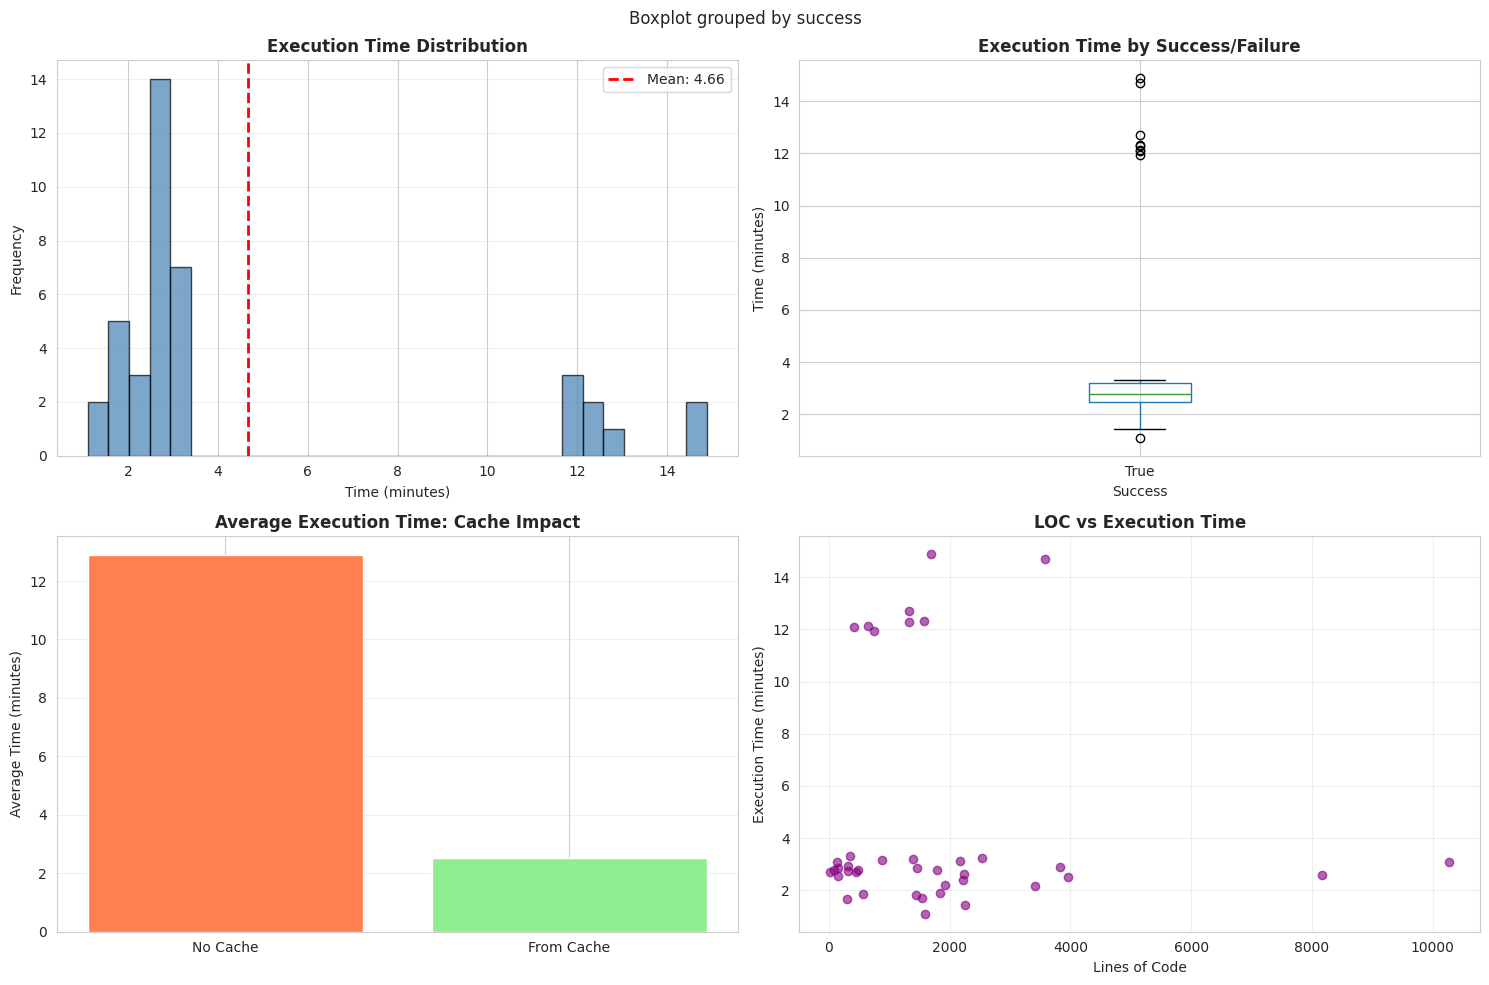

In [152]:
# Performance visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Execution time distribution
axes[0, 0].hist(df_filtered['elapsed_minutes'], bins=30, color='steelblue', edgecolor='black', alpha=0.7)
axes[0, 0].axvline(df_filtered['elapsed_minutes'].mean(), color='red', linestyle='--', 
                   linewidth=2, label=f'Mean: {df_filtered["elapsed_minutes"].mean():.2f}')
axes[0, 0].set_title('Execution Time Distribution', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Time (minutes)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].legend()
axes[0, 0].grid(axis='y', alpha=0.3)

# 2. Time by success/failure
df_filtered.boxplot(column='elapsed_minutes', by='success', ax=axes[0, 1])
axes[0, 1].set_title('Execution Time by Success/Failure', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Success')
axes[0, 1].set_ylabel('Time (minutes)')

# 3. Cache impact
cache_comparison = df_filtered.groupby('container_from_cache')['elapsed_minutes'].mean()
axes[1, 0].bar(['No Cache', 'From Cache'], cache_comparison.values, 
               color=['coral', 'lightgreen'])
axes[1, 0].set_title('Average Execution Time: Cache Impact', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Average Time (minutes)')
axes[1, 0].grid(axis='y', alpha=0.3)

# 4. LOC vs execution time
valid_data = df_filtered[df_filtered['static_total_loc'].notna() & df_filtered['elapsed_minutes'].notna()]
if len(valid_data) > 0:
    axes[1, 1].scatter(valid_data['static_total_loc'], valid_data['elapsed_minutes'], 
                       alpha=0.6, color='purple')
    axes[1, 1].set_title('LOC vs Execution Time', fontsize=12, fontweight='bold')
    axes[1, 1].set_xlabel('Lines of Code')
    axes[1, 1].set_ylabel('Execution Time (minutes)')
    axes[1, 1].grid(alpha=0.3)
else:
    axes[1, 1].text(0.5, 0.5, 'Insufficient data', ha='center', va='center', fontsize=12)
    axes[1, 1].set_title('LOC vs Execution Time', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

## 9. Export Utilities

Functions to export data and generate reports.

In [153]:
def export_summary_csv(df, output_path='results_summary.csv'):
    """Export a summary CSV of all results."""
    df.to_csv(output_path, index=False)
    print(f"Summary exported to {output_path}")

def generate_summary_report(df):
    """Generate a text summary report."""
    report = []
    report.append("=" * 80)
    report.append("PATCH VERIFICATION PIPELINE - SUMMARY REPORT")
    report.append("=" * 80)
    report.append(f"Generated: {pd.Timestamp.now()}")
    report.append(f"Total Instances: {len(df)}")
    report.append(f"Success Rate: {df['success'].mean()*100:.1f}%")
    report.append("")
    
    # Per-repository stats
    report.append("Repository Statistics:")
    for repo in df['repo'].unique():
        repo_df = df[df['repo'] == repo]
        report.append(f"\n  {repo}:")
        report.append(f"    Total: {len(repo_df)}")
        report.append(f"    Success: {repo_df['success'].sum()} ({repo_df['success'].mean()*100:.1f}%)")
        if repo_df['overall_score'].notna().any():
            report.append(f"    Avg Score: {repo_df['overall_score'].mean():.2f}")
    
    return "\n".join(report)

# Example: Export summary CSV
# export_summary_csv(df_filtered, 'results_summary.csv')

# Generate and print summary report
print(generate_summary_report(df_filtered))

PATCH VERIFICATION PIPELINE - SUMMARY REPORT
Generated: 2025-12-06 12:51:29.993928
Total Instances: 39
Success Rate: 100.0%

Repository Statistics:

  astropy:
    Total: 16
    Success: 16 (100.0%)
    Avg Score: 80.76

  django:
    Total: 7
    Success: 7 (100.0%)
    Avg Score: 78.43

  matplotlib:
    Total: 6
    Success: 6 (100.0%)
    Avg Score: 82.50

  scikit-learn:
    Total: 10
    Success: 10 (100.0%)
    Avg Score: 81.65
